# ERA-5 CAPE Pmax

### Importing libraries and setting plotting parameters

In [1]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings

from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')
#action = 'once' didn't seem to reduce the warnings at all

### Setting constants

In [2]:
#density of water (kg m-3)
rho = 1000 

#gravitational acceleration (m s-2)
g = 9.8 

#for relative humidity and saturation deficit
eps = 0.01802/0.02897

#pressure values of interest
p_vals = np.array([550,700,850,470])


Below we first begin by accessing the netCDF data and storing the cape and precipitation values into numpy arrays.

In [3]:
def file_concatenator(numerical_list):
    #Takes a list of numbers corresponding to filenumbers/years 
    #and compiles the corresponding list of filenames
    
    file_names = []
    
    #base directory where the desired files are located
    #basedir = '/work/bb1018/b380873/MCS_clim/ausgabe/meteo_clim/nc/ERAI/'
    # sylvia_20230822 > Changing basedir for Puma
    basedir = '/xdisk/sylvia/MCS_clim/ausgabe/meteo_clim/nc/ERAI/'
    
    #iterates through numbers
    for value in numerical_list:
        
        #appending list of files
        file_names = np.append(file_names,(basedir + 'colloc_' + str(value) + '_NZ.nc'))
        
    return file_names


def nc_open_compile(files,variable_name,compile_type='append'):
    #opens netcdf files, in a list, and either stacks or appends the data
    
    #files = list containing file names
    #variable_name is a string of the desired variable
    
    #opens a file in 'files' and extracts data for a given variable
    for i,file in enumerate(files):
        
        if i == 0:
            
            variable = (xr.open_dataset(file))[variable_name]
        
        else:
            
            #kwarg assumes append, but vstack can also be used
            if compile_type == 'stack':
            
                variable = np.vstack((variable,(xr.open_dataset(file))[variable_name]))
            
            else:
                
                variable = np.append(variable,(xr.open_dataset(file))[variable_name])
                   
    return variable

def negative_to_nan(array):
    #simply converts negatives to NaNs
    
    array = np.where(array<=0, np.NaN, array)
    
    return array

def nan_array(shape):
    
    an_array = np.empty(shape)

    an_array[:] = np.NaN
    
    return an_array

#array of years
years = np.arange(1983,2008)

#create list of file names
file_years = file_concatenator(years)

#creating cape array from different files and treating for negatives

cape_array = nc_open_compile(file_years,"cape")

cape = negative_to_nan(cape_array)

#applying same for pmax

pmax_array = nc_open_compile(file_years,"pmax")

pmax = negative_to_nan(pmax_array)


Finding the mean and percentiles of the data

In [4]:
def maxk_arg(matrix,k):
    #returns indices of max k elements in a matrix
    
    matrix_new = matrix.flatten()
    
    matrix_arg = np.argsort(matrix_new)
    
    return matrix_arg[-k:]


def bin_stat_function(n_bins,lower,upper,x_variable,y_variable,threshold=0,pc1=95,pc2=99.99,n_max=5):
    #Creates a range of bin values within which the data should lie, collects indices of x-variables
    #which fall in those bins and calls the corresponding y-variable values, calculates means
    #and percentiles. 
    
    #n_bins = number of bins, lower and upper = bounds of bins, threshold is a required number
    #of values to have if statistics are to be calculated, pc1,2 are percentiles, assumed 95 and 99
    
    cc = np.linspace(lower,upper,n_bins)
    
    #nan filled arrays created
    
    x_bins = nan_array((n_bins,1))
    y_bins = nan_array((n_bins,1))
    
    y_bins_pc1 = nan_array((n_bins,1))
    y_bins_pc2 = nan_array((n_bins,1))
    
    x_max = nan_array((n_bins,n_max))
    y_max = nan_array((n_bins,n_max))
    
    x_bins_error = nan_array((n_bins,1))
    y_bins_error = nan_array((n_bins,1))
    
    
    #reduced bin values for the loop below
    cc_red = cc[:-1]
    
    for i,value in enumerate(cc_red):
        
        #indices of values within bins
        j = np.where((x_variable >= value) & (x_variable < cc[i+1]))

        x_vals = x_variable[j]
        y_vals = y_variable[j]

        #threshold inspected    
        if len(j[0]) > threshold:
            
            #mean of x values within bin
            x_bins[i] = np.nanmean(x_vals)
            x_bins_error[i] = np.nanstd(x_vals)   
            
            #mean and percentiles of associated y variable
            y_bins[i] = np.nanmean(y_vals)
            y_bins_error[i] = np.nanstd(y_vals)
    
            y_bins_pc1[i] = np.nanpercentile(y_vals,pc1)
            y_bins_pc2[i] = np.nanpercentile(y_vals,pc2)

        if len(j[0]) >= n_max:
        
            j = maxk_arg(y_vals,n_max)

            
            x_max[i] = x_vals[j]
            
            y_max[i] = y_vals[j]
    

    return x_bins,y_bins,y_bins_pc1,y_bins_pc2,x_bins_error,y_bins_error,x_max,y_max


#bin_stat_function called and assigned to cape values and associated precipitation
cape_bins,pmax_bins,pmax_95_bins,pmax_99_bins,cape_error,pmax_error,cape_max,p_max = bin_stat_function(50,0,4500,cape,pmax,threshold=20)  


Extracting pressure from the data files

In [5]:
#water vapour levels opened and vstacked, negatives removed
qv_array = nc_open_compile(file_years,"qvpre",'stack')

print(qv_array)

qv = negative_to_nan(qv_array) # not sure if this needed????

#pressure level values converted into double point precision
plev = np.double((xr.open_dataset(file_years[0])).pressure.data)

#integral computed using trapezoidal integration
integral = np.trapz(x=(np.array(plev))*100,y=qv)

#cwvc calculated 
cwvc = (1/(rho*g))*integral*1000

[[  3.25606288e-06   7.17295006e-06   1.85319223e-05 ...,   1.58686060e-02
    1.66703928e-02   1.67444218e-02]
 [  4.03944023e-06   8.34801631e-06   1.89236107e-05 ...,   1.67812407e-02
    1.68223679e-02   1.68576203e-02]
 [  3.64775156e-06   5.60619492e-06   1.77485454e-05 ...,   1.65791307e-02
    1.66570749e-02   1.67589150e-02]
 ..., 
 [  2.71535419e-06   3.96327141e-06   7.29105068e-06 ...,   1.58866215e-02
    1.63537581e-02   1.67372860e-02]
 [  1.88340948e-06   3.96327141e-06   1.22827196e-05 ...,   1.19369635e-02
    1.20838024e-02   1.22689102e-02]
 [  3.96327141e-06   5.21118864e-06   1.06188299e-05 ...,   1.60288848e-02
    1.62239745e-02   1.63866207e-02]]


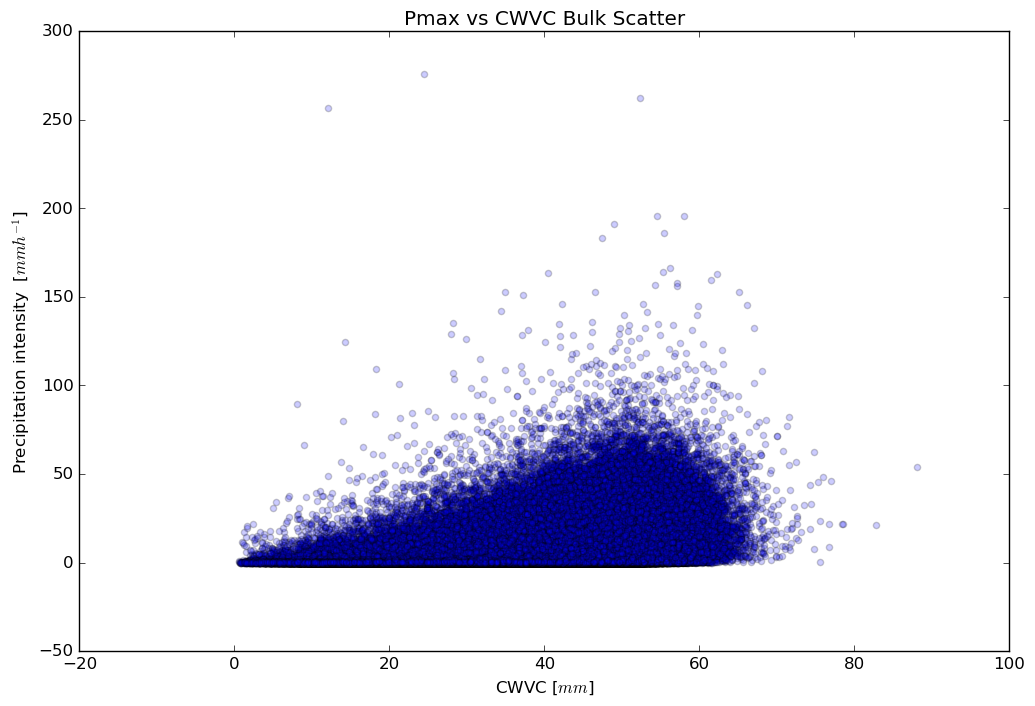

In [6]:
#scattering of all cwvc points, illustrates non linear system
#commented out to save processing time


fig,ax = plt.subplots(1,1,figsize=(12,8))

ax.scatter(cwvc,pmax,alpha=0.2)

ax.set(xlabel = "CWVC [$mm$]")
ax.set(ylabel = "Precipitation intensity  [$mm h^{-1}$]")
ax.set_title("Pmax vs CWVC Bulk Scatter")

plt.show()


The above simple scatter of the precipitation values against CWVC reveals the non-monotonicity of the two variables. The Precipitation intensity seems to grow with increasing CWVC, before dropping towards 0 precipitation intensity.

In [7]:
#cwvc and precip bins are assigned
cwvc_bins,pmax_bins_2,pmax_95_bins_2,pmax_99_bins_2,cwvc_error,pmax_error_2,cwvc_max,p_max_2 = bin_stat_function(35,5,65,cwvc,pmax,threshold=10)

### Plotting cape and precipitation

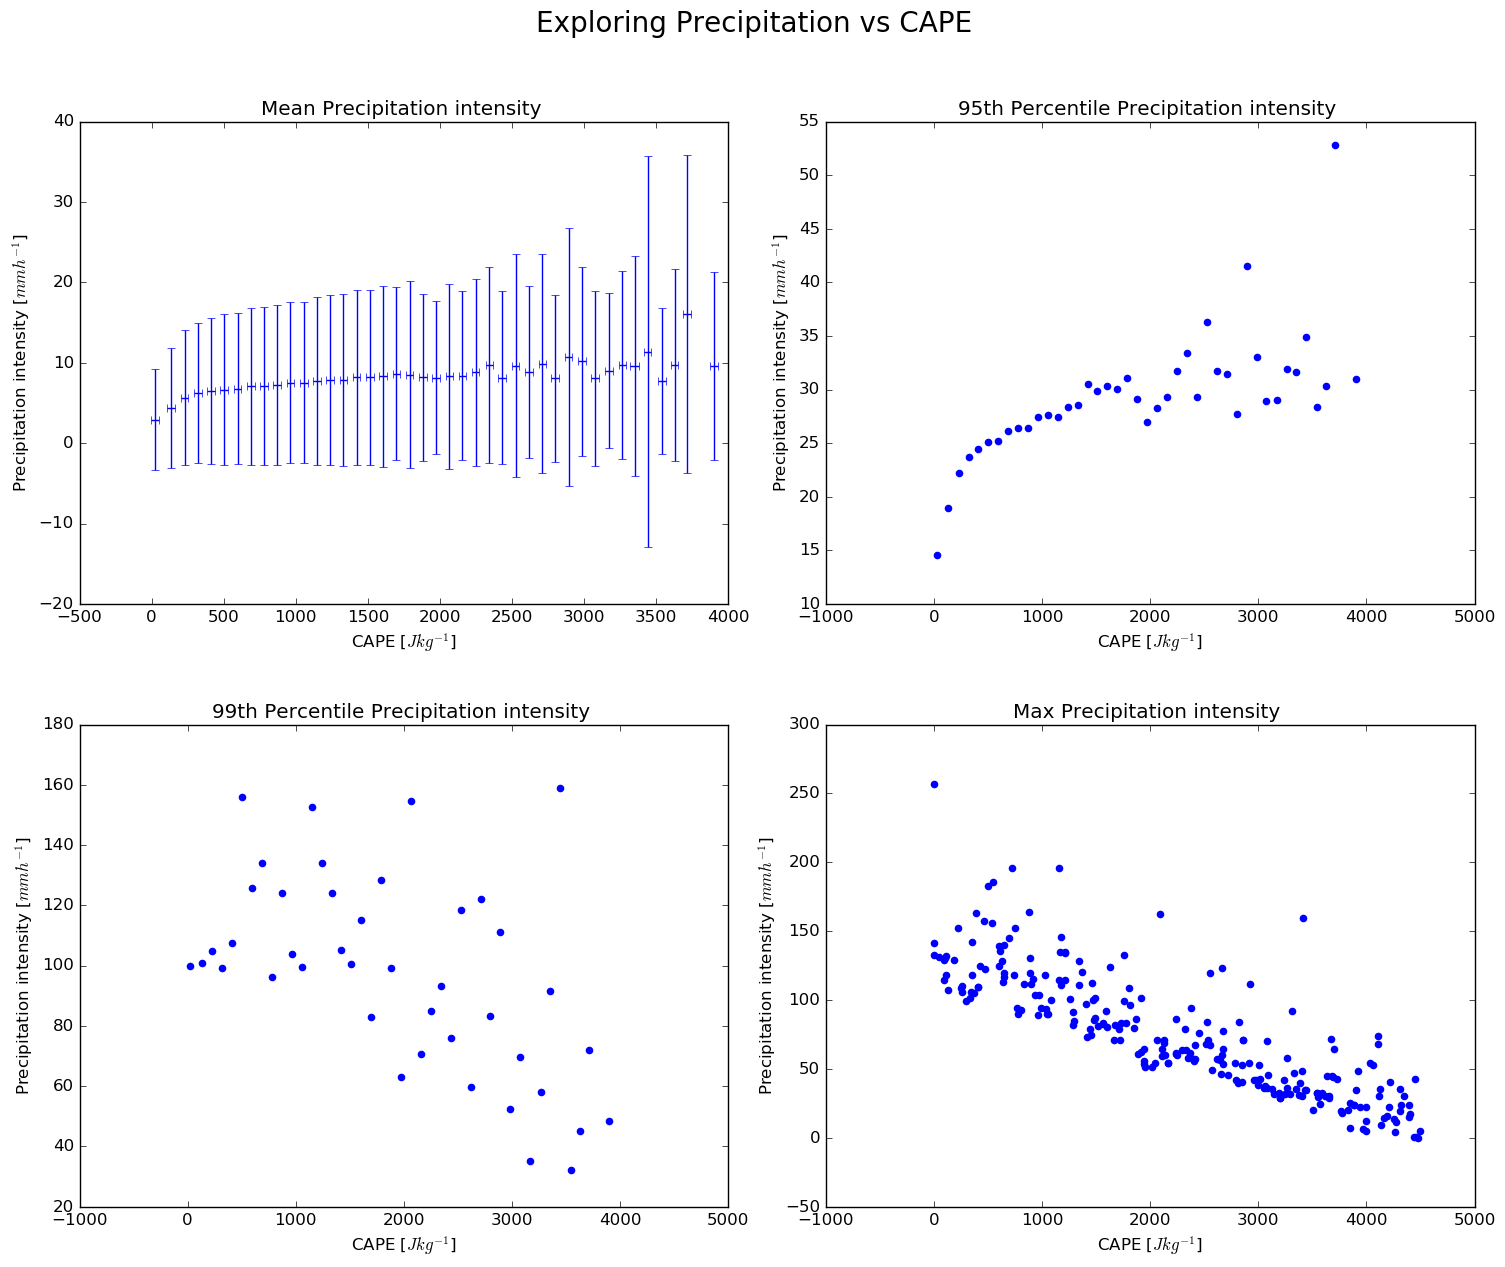

In [8]:
#arrays for the 3 precip data and for both cape and cwvc are listed
precip_bin_arrays = [pmax_bins,pmax_95_bins,pmax_99_bins,p_max]

precip_bin_arrays_2 = [pmax_bins_2,pmax_95_bins_2,pmax_99_bins_2,p_max_2]

def mean_pc_max_plot(x_bins,y_arrays,errors,labels,percentiles=[95,99]):
    #plots x bin values against precip bin values
    
    #y_arrays has format: [y mean, y pc1, y pc2, y max]
    #errors has format: [x error,y error]
    #labels has format: [suptitle,[x_name,x_unit],[y_name,y_unit]],strings
    #percentiles has format: [percentile 1, percentile 2]

    fig, ax = plt.subplots(2,2, figsize =(18,14))
    
    fig.suptitle(labels[0],fontsize =20)
    
    #list of labels to be iterated through
    title_terms = ['Mean','{}th Percentile'.format(percentiles[0]),
                   '{}th Percentile'.format(percentiles[1]),'Max']
                       
    #ax.flat allows iteration through the subplots
    for i, axis in enumerate(ax.flat): 
       
        if i == 0:
            
            axis.errorbar(x_bins[0].flatten(), (y_arrays[i]).flatten(),xerr=errors[0].flatten(),
                          yerr=errors[1].flatten(), color = 'blue',ls='none')
            
        elif i == 3:
            
            axis.scatter(x_bins[1].flatten(), (y_arrays[i]).flatten(),color = 'blue')
            
        else:
            
            #arrays flattened, precip arrays iterated through
            axis.scatter(x_bins[0].flatten(), (y_arrays[i]).flatten(), color = 'blue')
          
        #x variable unit and name formatted in
        axis.set(xlabel = labels[1][0] + " [${}$]".format(labels[1][1]))
        axis.set(ylabel = labels[2][0] + " [${}$]".format(labels[2][1]))
        axis.set_title(title_terms[i] + " {} ".format(labels[2][0]))
    
    #space between plots adjusted
    plt.subplots_adjust(wspace=.15, hspace=0.25)
        
    plt.show()

precip_cape_labels = ['Exploring Precipitation vs CAPE',['CAPE','J kg^{-1}'],['Precipitation intensity','mm h^{-1}']]

mean_pc_max_plot([cape_bins,cape_max],precip_bin_arrays,[cape_error,pmax_error],precip_cape_labels)

We note above the differences in the plots for the different regimes, mean, upper percentiles and a number of max values. The mean and 95th percentile plots demonstrate an initial steep increased from around 0 to 200, before then adopting a less steep increase. These two portions resemble a logarithmic style increase, especially the mean plot. However, the transition from 95th to 99.99th percentile completely changes the nature of the plot. We now observe that the most extreme values actually decrease with increasing CAPE. The final plot takes a number of the greatest values in each bin, here we see the linear decrease is preserved. These plots demonstrate non-monatonicity in the relationship between precipitation intensity and CAPE.

## Figure 1

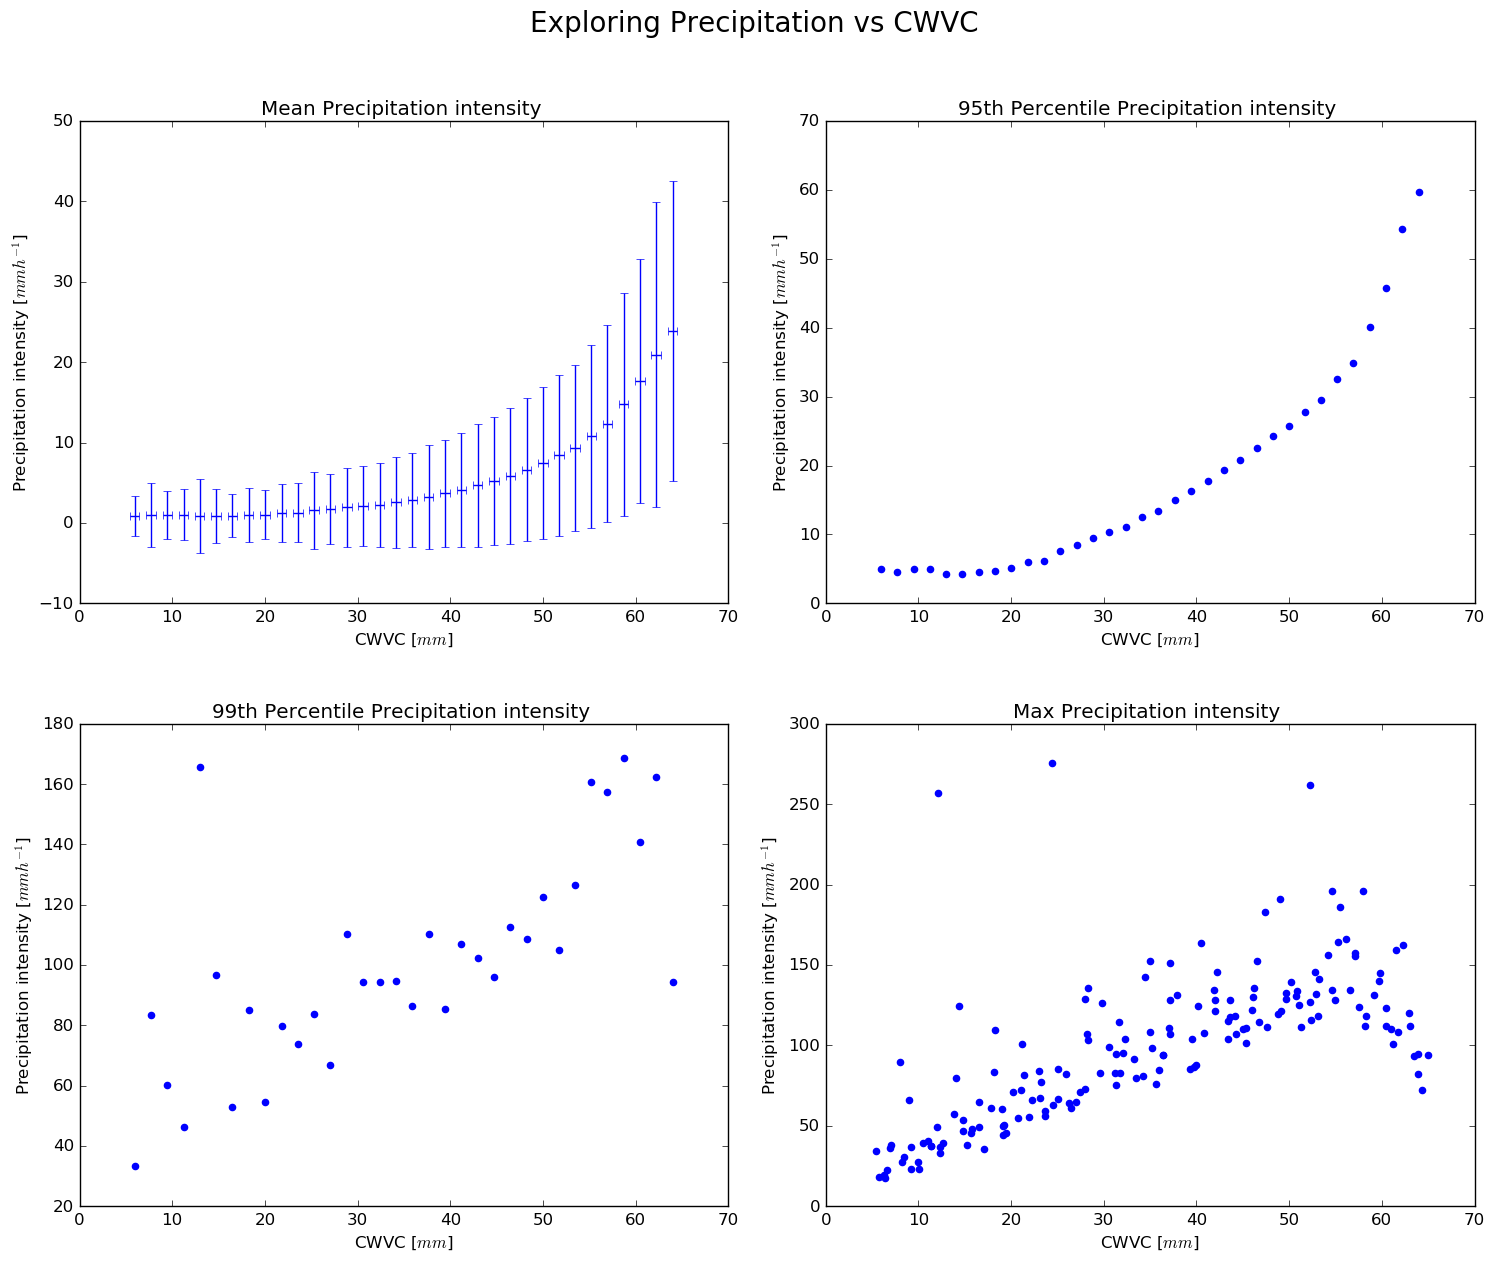

In [9]:
precip_cwvc_labels = ['Exploring Precipitation vs CWVC',['CWVC','mm'],['Precipitation intensity','mm h^{-1}']]

mean_pc_max_plot([cwvc_bins,cwvc_max],precip_bin_arrays_2,[cwvc_error,pmax_error_2],precip_cwvc_labels,)

The above set of plots considers the relationship between precipitation intensity and column water vapour content (CWVC). The mean value plot demonstrates what appears to be roughly exponential behaviour. While the form is generally supported by the second plot, concerning the 95th percentile, the exponential behaviour is less clear and breaks down a bit. The 99th percentile maintains a positive trend but now with a linear relationship. Lastly, sampling multiple max values in each CWVC bin reveals the non-monotonicity present in the bulk scatter plot before. This suggests increasing water vapour content will yield greater precipitation intensity only past a certain point.

We now wish to explore the relationship of pressure Velocity against CAPE and also precipitation intensity against pressure velocity. We first begin by considering cape against all pressure velocities, negative or positive.

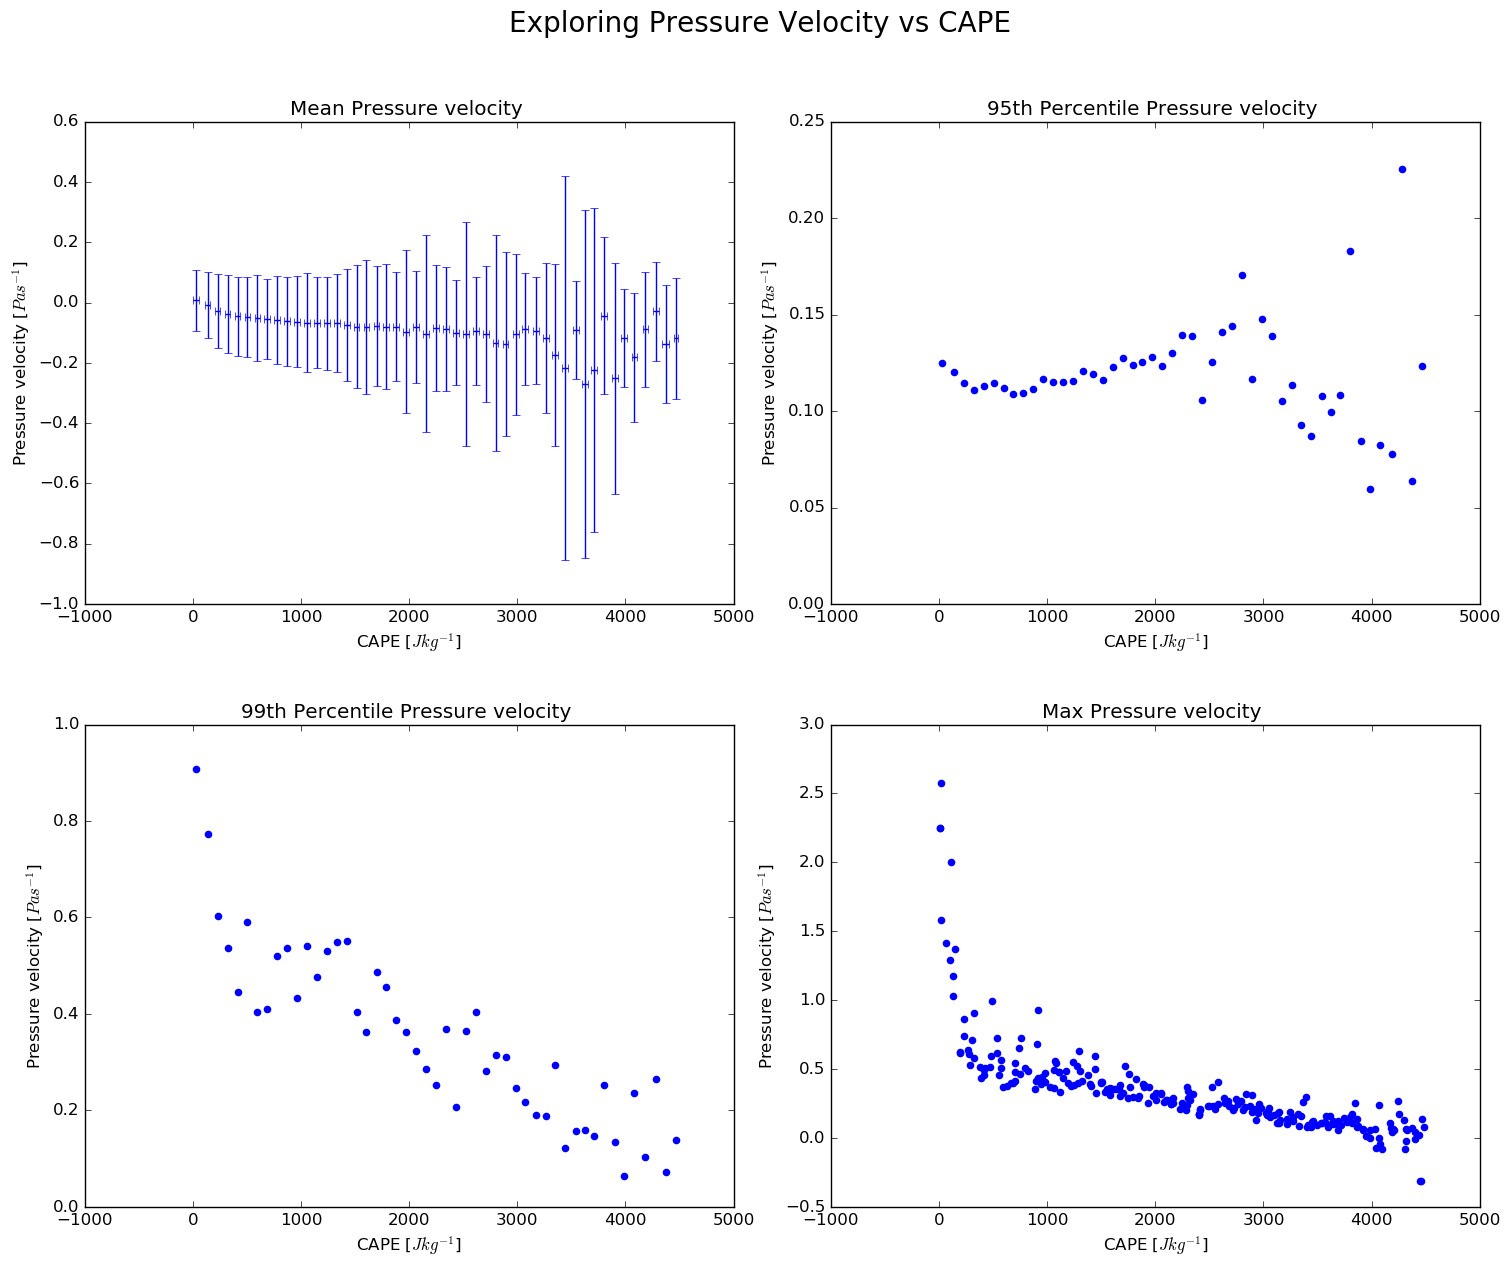

In [10]:
#w is data is stacked and then the 15th altitude column is taken
w_array = nc_open_compile(file_years,'w','stack')

w_array_mid = w_array[:,14]

#bin_stat_function called and assigned to cape values and associated precipitation
cape_bins_w,wc_bins,wc_95_bins,wc_99_bins,cape_error_w,wc_error,cape_max_w,wc_max = bin_stat_function(50,0,4500,cape,w_array_mid,threshold=5)  

arrays_w = [wc_bins,wc_95_bins,wc_99_bins,wc_max]

#mean_pc_max_plot([cwvc_bins,cwvc_max],precip_bin_arrays_2,[cwvc_error,pmax_error_2],precip_cwvc_labels,[95,99])


wc_labels = ['Exploring Pressure Velocity vs CAPE',['CAPE','J kg^{-1}'],['Pressure velocity','Pa s^{-1}']]

mean_pc_max_plot([cape_bins_w,cape_max_w],arrays_w,[cape_error_w,wc_error],wc_labels)



Pressure velocity is plotted against CAPE above. For the mean pressure velocity against CAPE, the trend appears strongly linear, although breaking down towards the higher values of CAPE. However, moving into the 95th percentile completely breaks this trend, producing something fairly uninterpretable. The 99th and Max plots then illustrate a decidedly negative trend between precipitation and CAPE.

Pressure velocity, however, can clearly be negative or positive, so it may be interesting to break down the measurements into positive or negative velocities, to see if there are different interactions with CAPE.

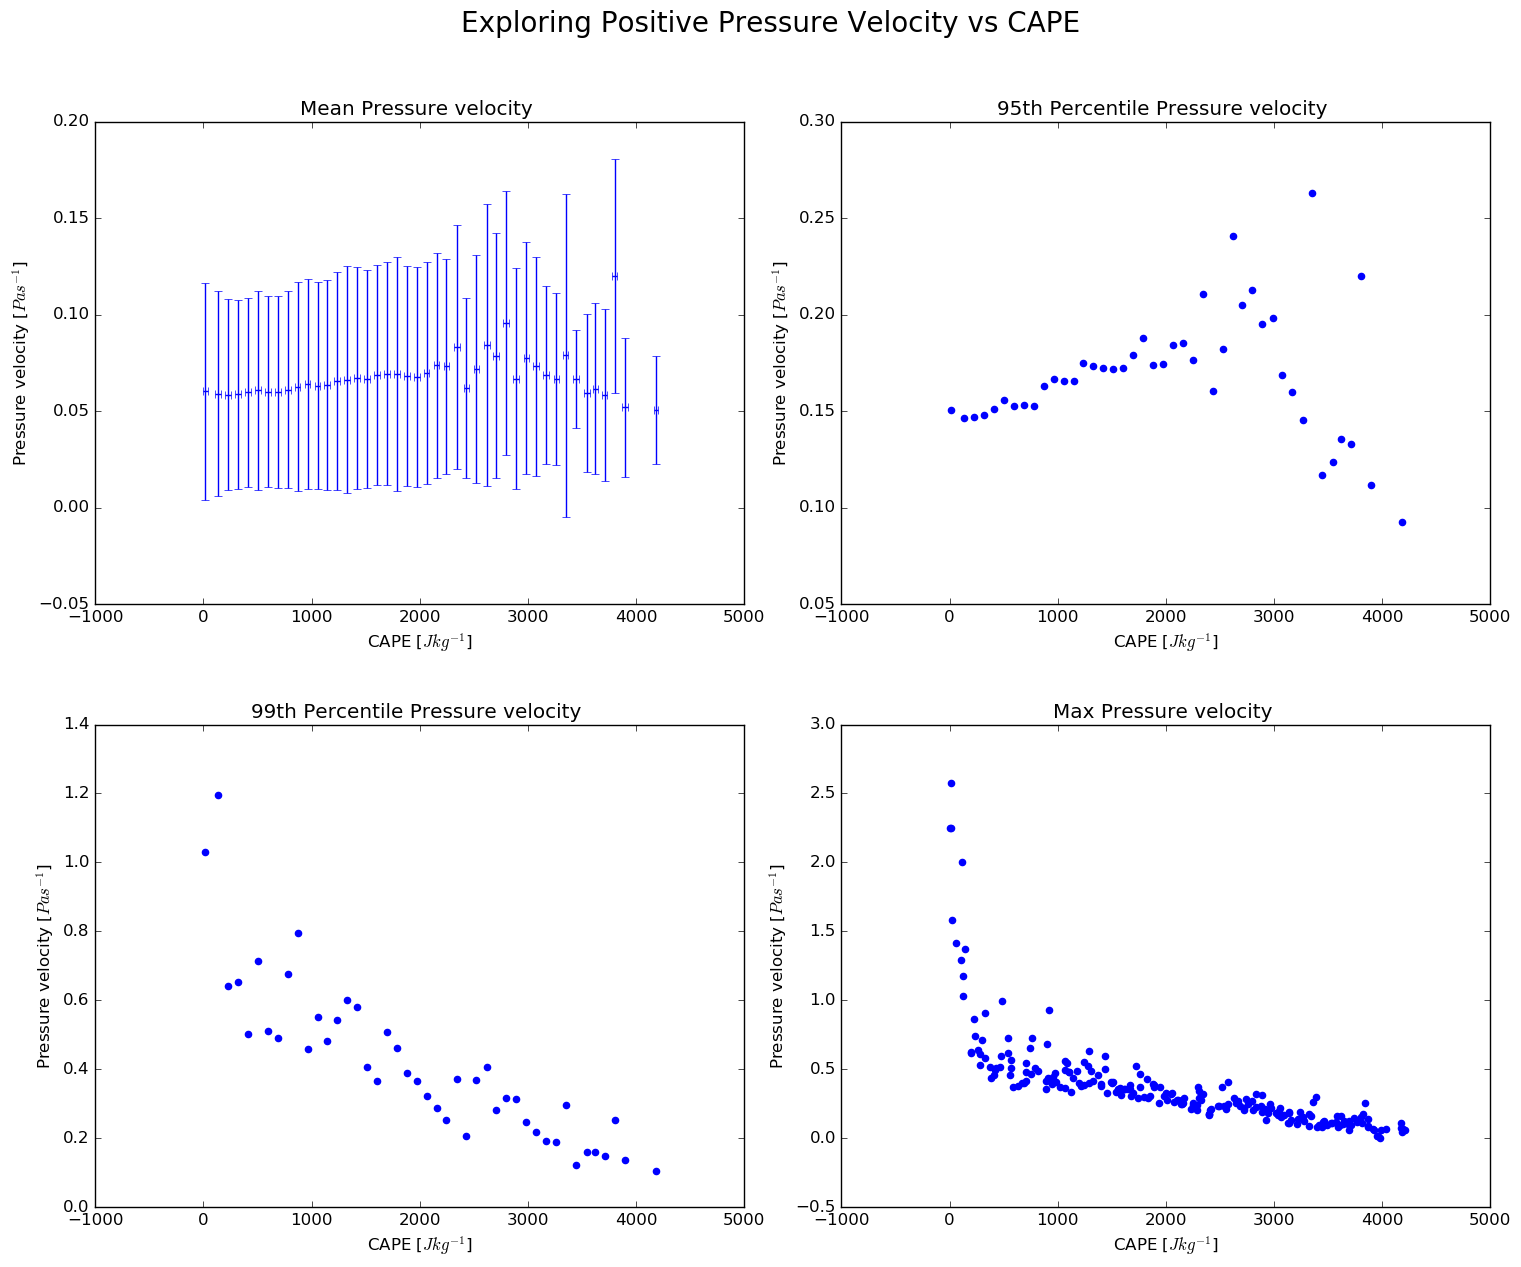

In [11]:
def positive_vals(y,x):
    #function to take negative values in some array y and couple with corresponding x values
    
    #taking array values less than 0, negative values
    indices = np.where(y>=0)

    #creating a new array of just negative values from w
    y_p = y[indices]

    #taking cape values corresponding to negative w
    x_p = x[indices]

    #making the values positive for logarithms
    y_p = abs(y_p)
    
    return y_p,x_p

w_array_p,cape_array_p = positive_vals(w_array_mid,cape_array)

#bin_stat_function called and assigned to cape values and associated precipitation
cape_bins_wp,wcp_bins,wcp_95_bins,wcp_99_bins,cape_error_wp,wcp_error,cape_max_wp,wcp_max = bin_stat_function(50,0,4500,cape_array_p,w_array_p,threshold=5)  

arrays_wp = [wcp_bins,wcp_95_bins,wcp_99_bins,wcp_max]

wcp_labels = ['Exploring Positive Pressure Velocity vs CAPE',['CAPE','J kg^{-1}'],['Pressure velocity','Pa s^{-1}']]

mean_pc_max_plot([cape_bins_wp,cape_max_wp],arrays_wp,[cape_error_wp,wcp_error],wcp_labels)


We observe no enormous changes in the graphs, however the mean plot changes in an important way. The trend shown in the mean plot is now largely positive, before peaking and then decreasing. This resembles the previously confusing 95th percentile plot and suggests that there is a CAPE threshold for increasing pressure velocity until we approach the 99.99th percentile. At this percentile, shown in the bottom left, a clear downwards trend is observed. This is supported by the maximum plot, to the right.

Next, we consider the negative pressure velocities.

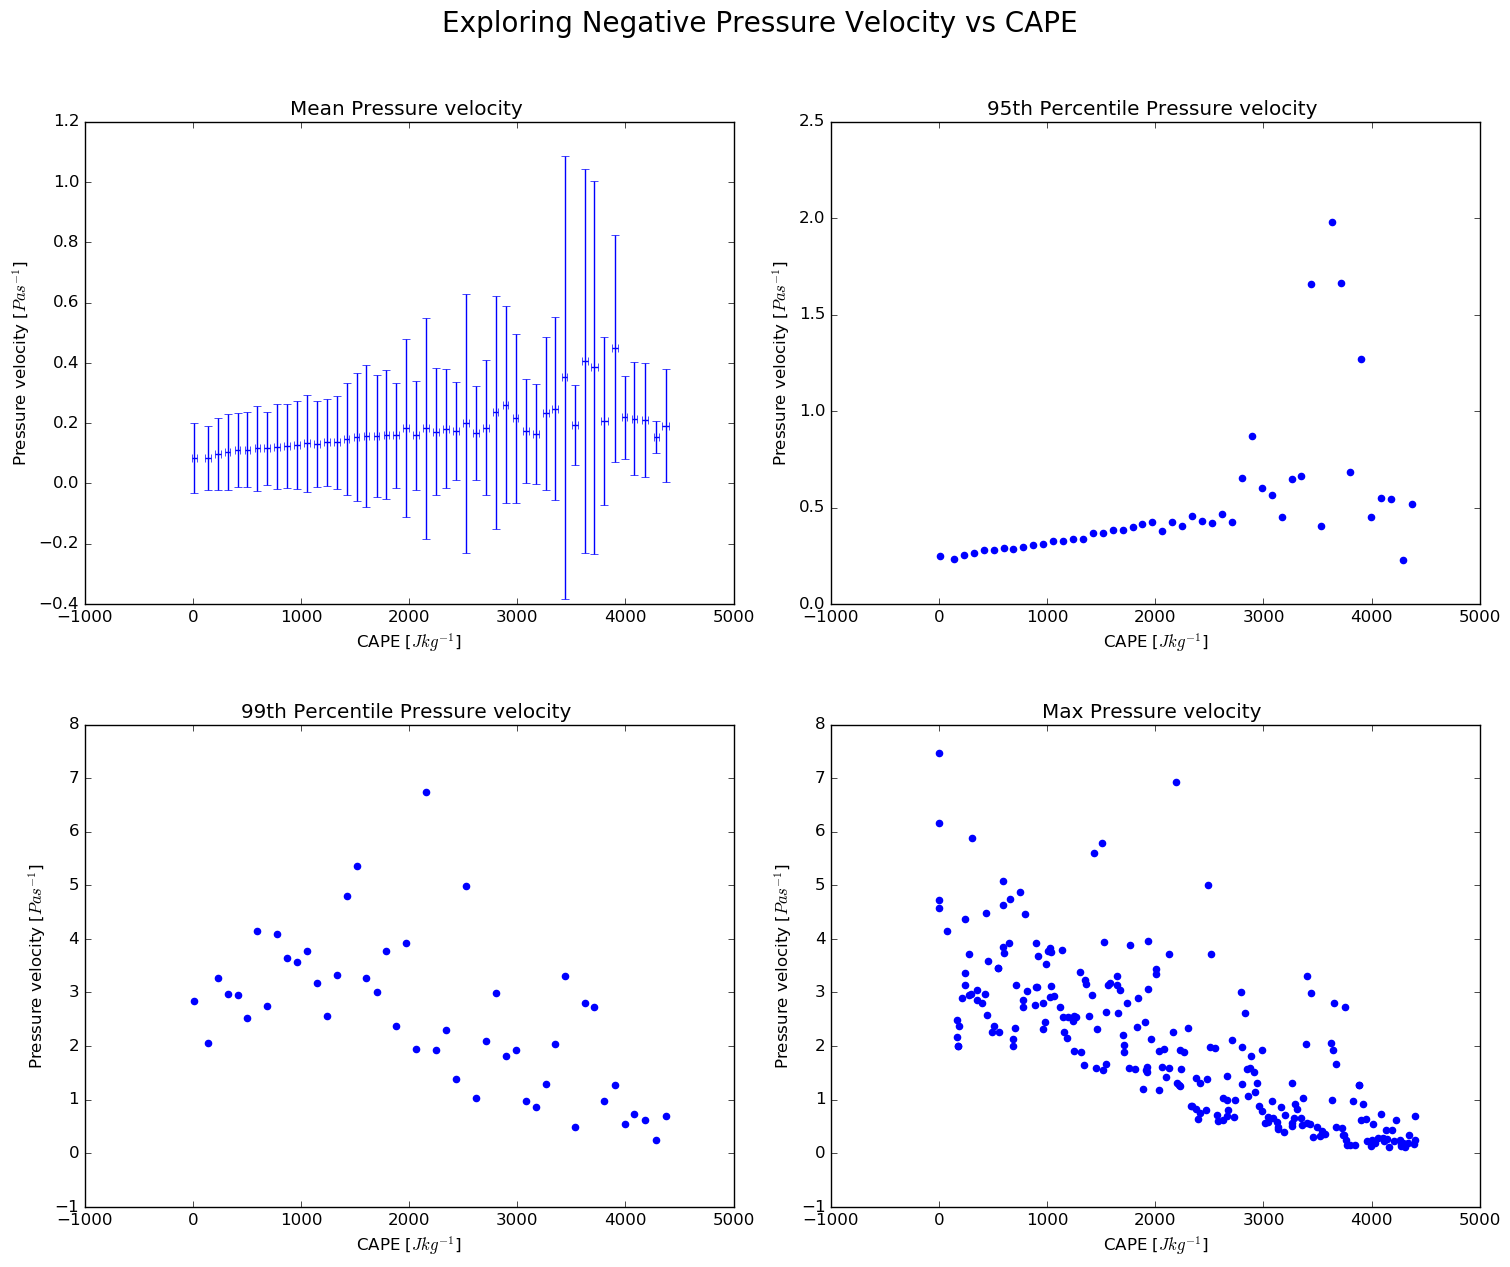

In [12]:
def negative_vals(y,x):
    #function to take negative values in some array y and couple with corresponding x values
    
    #taking array values less than 0, negative values
    indices = np.where(y<0)

    #creating a new array of just negative values from w
    y_n = y[indices]

    #taking cape values corresponding to negative w
    x_n = x[indices]

    #making the values positive for logarithms
    y_n = abs(y_n)
    
    return y_n,x_n

w_array_n,cape_array_n = negative_vals(w_array_mid,cape_array)

#bin_stat_function called and assigned to cape values and associated precipitation
cape_bins_wn,wcn_bins,wcn_95_bins,wcn_99_bins,cape_error_wn,wcn_error,cape_max_wn,wcn_max = bin_stat_function(50,0,4500,cape_array_n,w_array_n,threshold=5)  

arrays_wn = [wcn_bins,wcn_95_bins,wcn_99_bins,wcn_max]

wcn_labels = ['Exploring Negative Pressure Velocity vs CAPE',['CAPE','J kg^{-1}'],['Pressure velocity','Pa s^{-1}']]

mean_pc_max_plot([cape_bins_wn,cape_max_wn],arrays_wn,[cape_error_wn,wcn_error],wcn_labels)

The above plots are for negative pressure velocities. We observe a positive trend in the mean and 95th percentile, however both these plots do not illustrate the clear downturn as in the positive case. The values do still appear to become more random at around 3000 J/kg, however. More chaotic and less clear negative trends are also illustrated in the last two panels.

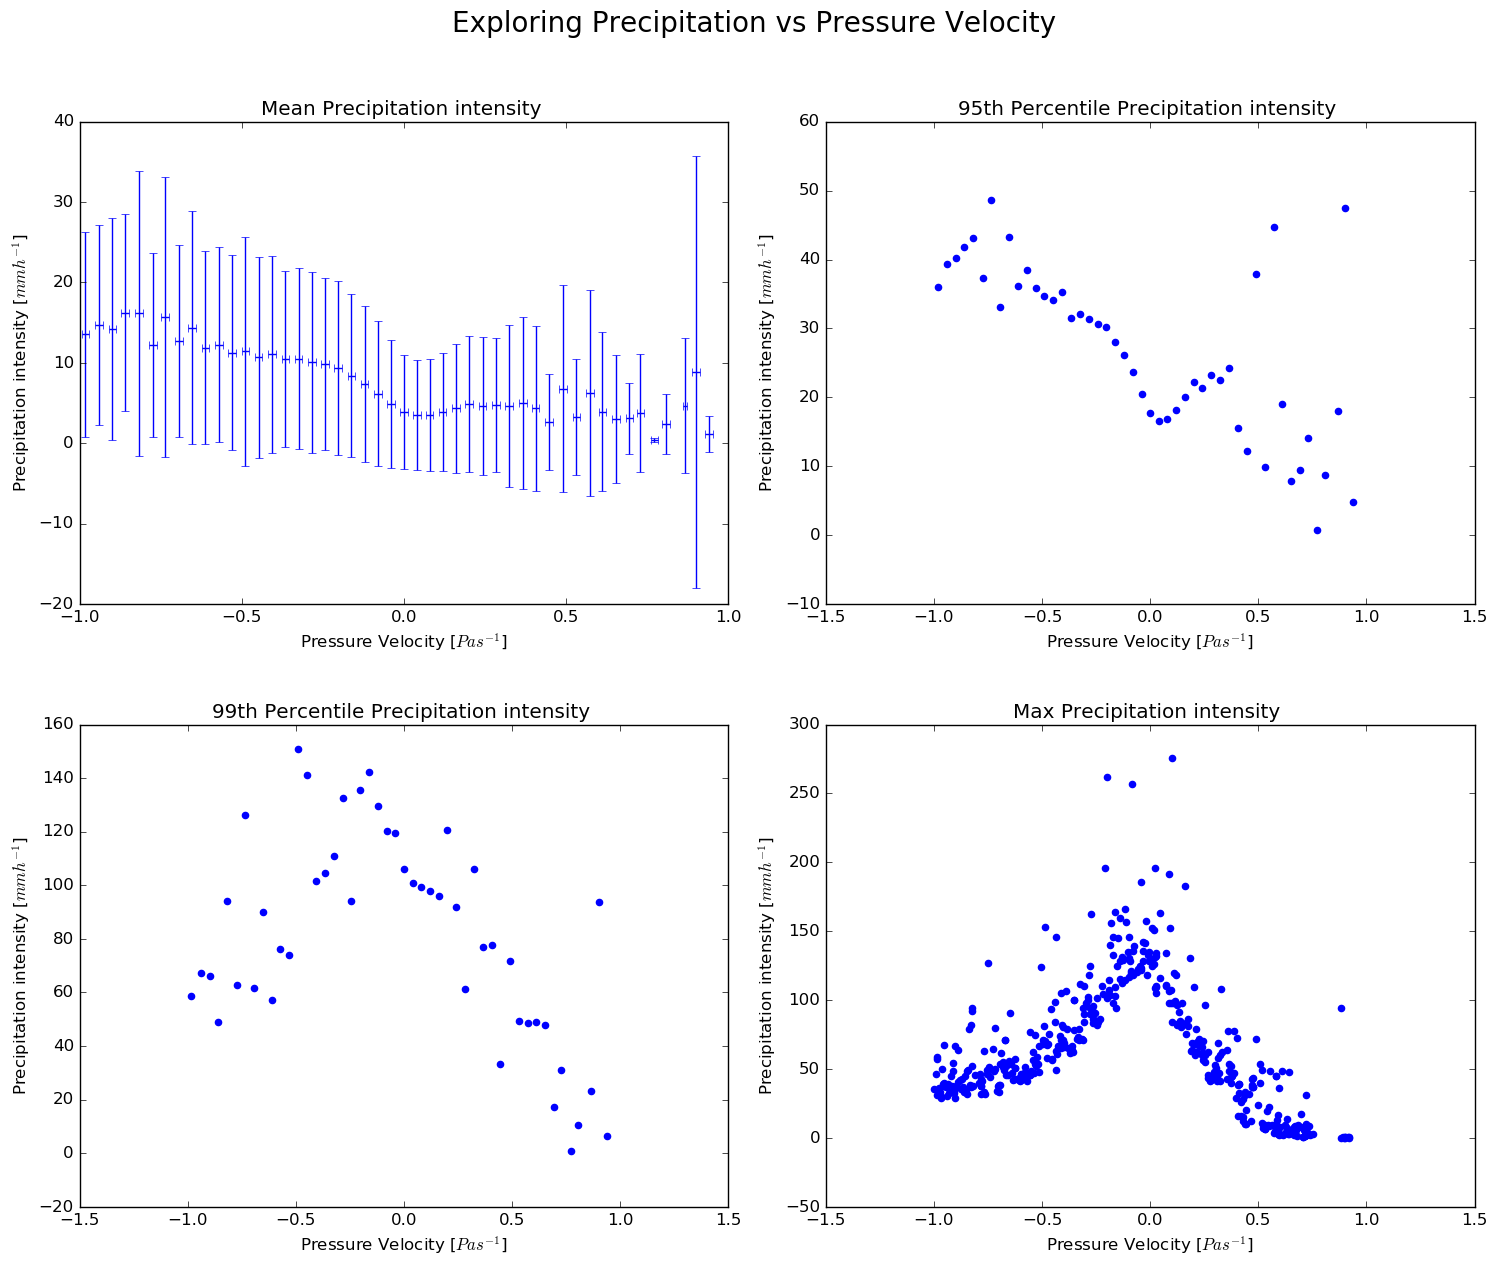

In [13]:
#bin_stat_function called and assigned to cape values and associated precipitation
wp_bins,pw_bins,pw_95_bins,pw_99_bins,wp_error,pw_error,wp_max,pw_max = bin_stat_function(50,-1,1,w_array_mid,pmax,threshold=5,n_max=10) 

arrays_pw = [pw_bins,pw_95_bins,pw_99_bins,pw_max]

#precip_plot([wp_bins,wp_max],['Pressure Velocity','Pa s^{-1}'],arrays_pw,wp_error,pw_error)

precip_w_labels = ['Exploring Precipitation vs Pressure Velocity',['Pressure Velocity','Pa s^{-1}'],['Precipitation intensity','mm h^{-1}']]

mean_pc_max_plot([wp_bins,wp_max],arrays_pw,[wp_error,pw_error],precip_w_labels)


Exploring the relationship between precipitation and Pressure velocity, we observe strange behaviour. For the mean, there appears to be a negative gradient associated with precipitation intensity against increasing ( more positive) pressure velocity. However, there is a clear dip around 0 pressure velocity in the mean. This dip is then even clearer in the 95th percentile. Additionally, the negative slop is also present stronger here. The 99.99th percentile loses the dip and the whole form changes, in general. The 99.99th percentile no longer has a simply negative slope, but one which increases sharply before then dropping off after around -0.25,0. The Max plot actually then shows a very sharp peak approximately around 0 pressure velocity. 

Below we investigate this dip for different percentiles and different pressure levels.

9 9
9


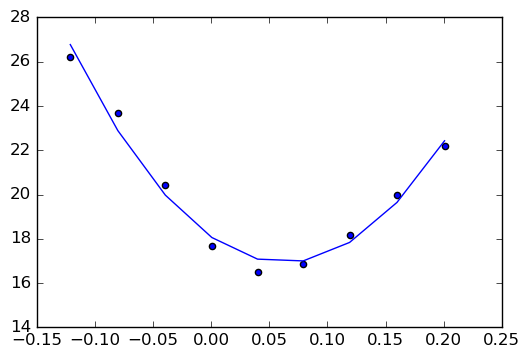

In [14]:
def find_3(x_array,value,number):
    #function to find 'number' of initial values in 'array' greater
    #than some 'value'
    
    #index of closest element to desired value
    k = np.nanargmin(abs(x_array-value))
    
    #take a number of indices either side of the value of interest
    indices = np.arange((k-(number)),(k+(number+1)))
    
        
    return indices


def dip_find(indices,y_array,number):
    
    k = np.nanargmin(abs(y_array[indices]))

    new_indices = np.arange((indices[k]-(number)),(indices[k]+(number+1)))
    
    return new_indices

def quadratic(data,a,b,c):
    
    return a*data**2 + b*data + c
    

zero_w_i = find_3(wp_bins,0,4)

dip_w_i = dip_find(zero_w_i,pw_95_bins,4)

wp_dip = wp_bins[dip_w_i]

pw_dip = pw_95_bins[dip_w_i]

print(len(wp_dip),len(pw_dip))

ppar_q,pcov_q = curve_fit(quadratic,(wp_dip[~np.isnan(wp_dip)]).flatten(),(pw_dip[~np.isnan(pw_dip)]).flatten())

quadratic_vals = quadratic(wp_dip,ppar_q[0],ppar_q[1],ppar_q[2])

print(len(quadratic_vals))

plt.scatter(wp_dip,pw_dip)

plt.plot(wp_dip,quadratic_vals)

plt.show()

### Curve fitting

A logarithmic fit is applied to the CAPE-Precipitation plot, while an exponential curve is fitted to the CWVC-Precipitaion plot.

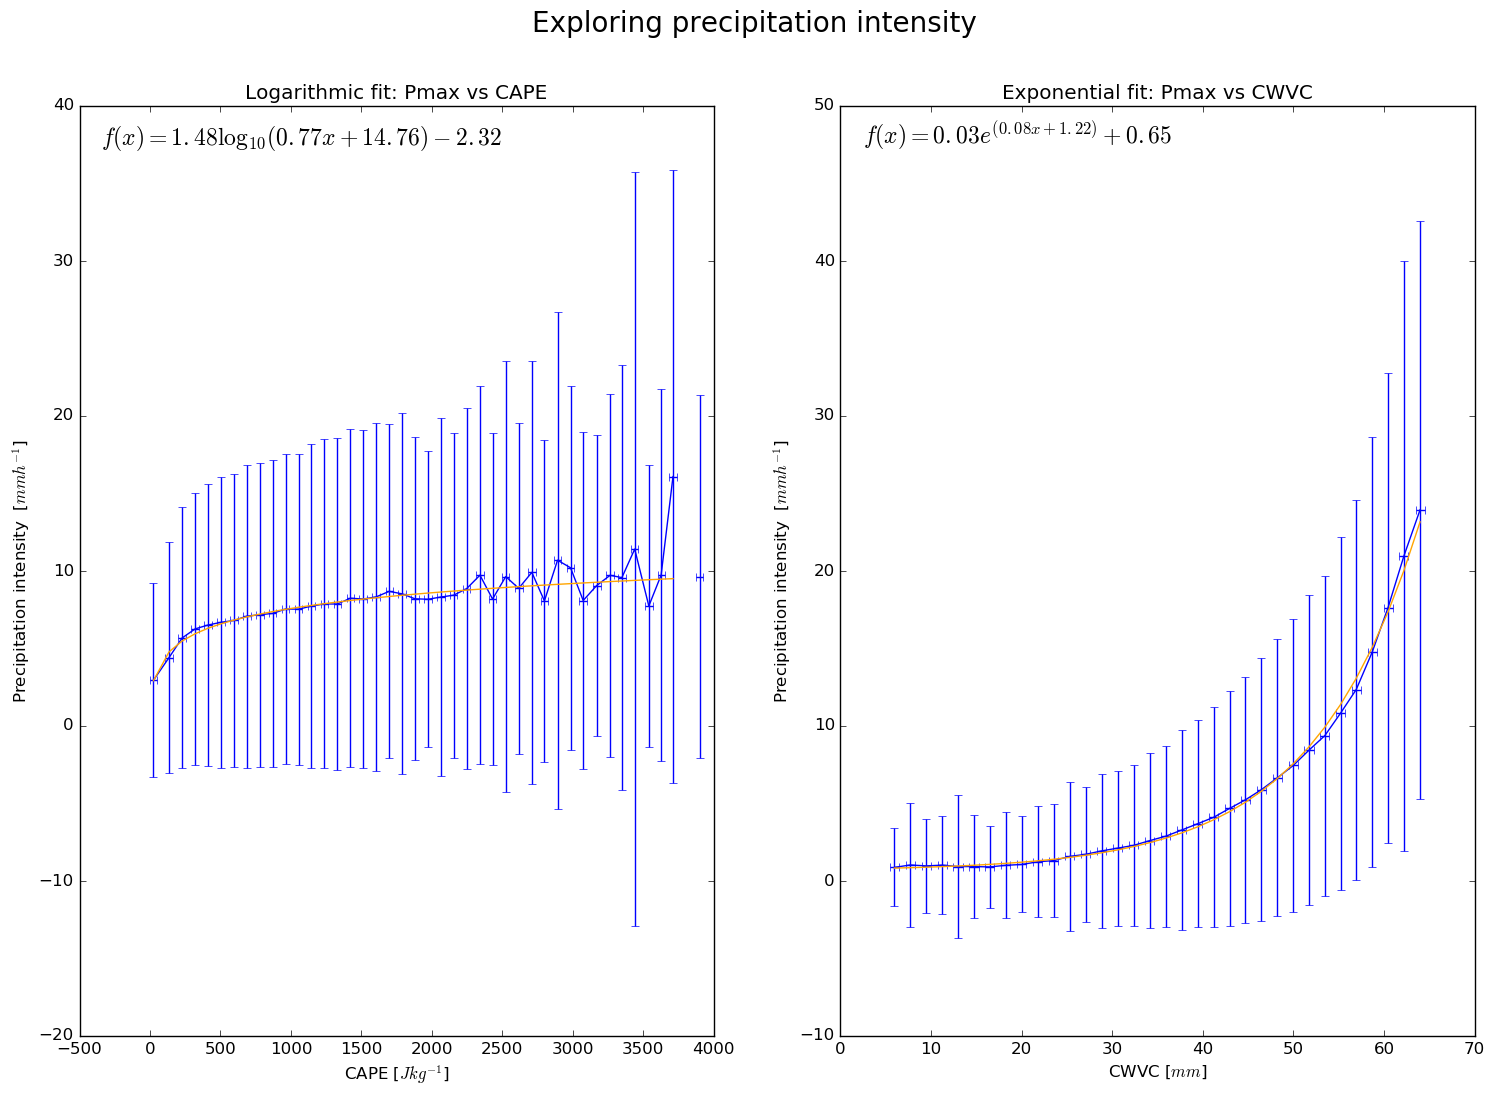

In [15]:
#### curve fitting
def logarithm_function(x_data,a,b,c,d):
    #simple log function for fitting
    
    return (a*np.log(b*x_data + c) + d)

def exponential_function(x_data,a,b,c,d):
    #simple exponential function for fitting
    
    return a*np.exp(b*x_data + c) + d 


    
#extracting fit parameters and covariance matrix for logarithm function    
ppar_l,pcov_l = curve_fit(logarithm_function, (cape_bins[~np.isnan(cape_bins)]).flatten(), 
                          (pmax_bins[~np.isnan(pmax_bins)]).flatten(),sigma=pmax_error[~np.isnan(pmax_error)].flatten())

#using the fit parameters to produce new y values
log_values = logarithm_function(cape_bins.flatten(),ppar_l[0],ppar_l[1],ppar_l[2],ppar_l[3])


#extracting fit parameters and covariance matrix for exponential function  
ppar_e,pcov_e = curve_fit(exponential_function, (cwvc_bins[~np.isnan(cwvc_bins)]).flatten(), 
                          (pmax_bins_2[~np.isnan(pmax_bins_2)]).flatten(),sigma=pmax_error_2[~np.isnan(pmax_error_2)].flatten())

#using the fit parameters to produce new y values
exp_values = exponential_function(cwvc_bins.flatten(),ppar_e[0],ppar_e[1],ppar_e[2],ppar_e[3])



#creating a figure object
fig,(ax1,ax2) = plt.subplots(1,2, figsize =(18,12))

#creating superior title
fig.suptitle('Exploring precipitation intensity',fontsize =20)

#errorbar plots 
ax1.errorbar(cape_bins.flatten(),pmax_bins.flatten(),
                             xerr=cape_error, yerr=pmax_error,color = 'blue')

#fitted function plotted against data
ax1.plot((cape_bins.flatten()),log_values,color ='orange')

#plot attributes
ax1.set(xlabel = "CAPE [$J kg^{-1}$]")
ax1.set(ylabel = "Precipitation intensity  [$mm h^{-1}$]")
ax1.set_title("Logarithmic fit: Pmax vs CAPE")

#figure text with fit parameters and function
ax1.text(-350,37.5,'$f(x) = {0:.2f} \log_{{10}}({1:.2f}x + {2:.2f})'
         ' {3:.2f}$'.format(ppar_l[0],ppar_l[1],ppar_l[2],ppar_l[3]), fontsize =17)



#errorbar plots 
ax2.errorbar(cwvc_bins.flatten(),pmax_bins_2.flatten(),xerr=cwvc_error,
             yerr=pmax_error_2, color = 'blue')

#fitted function plotted against data
ax2.plot((cwvc_bins.flatten()),exp_values,color ='orange')

#plot attributes              
ax2.set(xlabel = "CWVC [$mm$]")
ax2.set(ylabel = "Precipitation intensity  [$mm h^{-1}$]")
ax2.set_title("Exponential fit: Pmax vs CWVC")

#figure text with fit parameters and function
ax2.text(2.5,47.5,'$f(x) = {0:.2f} e^{{({1:.2f}x + {2:.2f})}}'
         '+ {3:.2f}$'.format(ppar_e[0],ppar_e[1],ppar_e[2],ppar_e[3]), fontsize =17)



plt.show()   


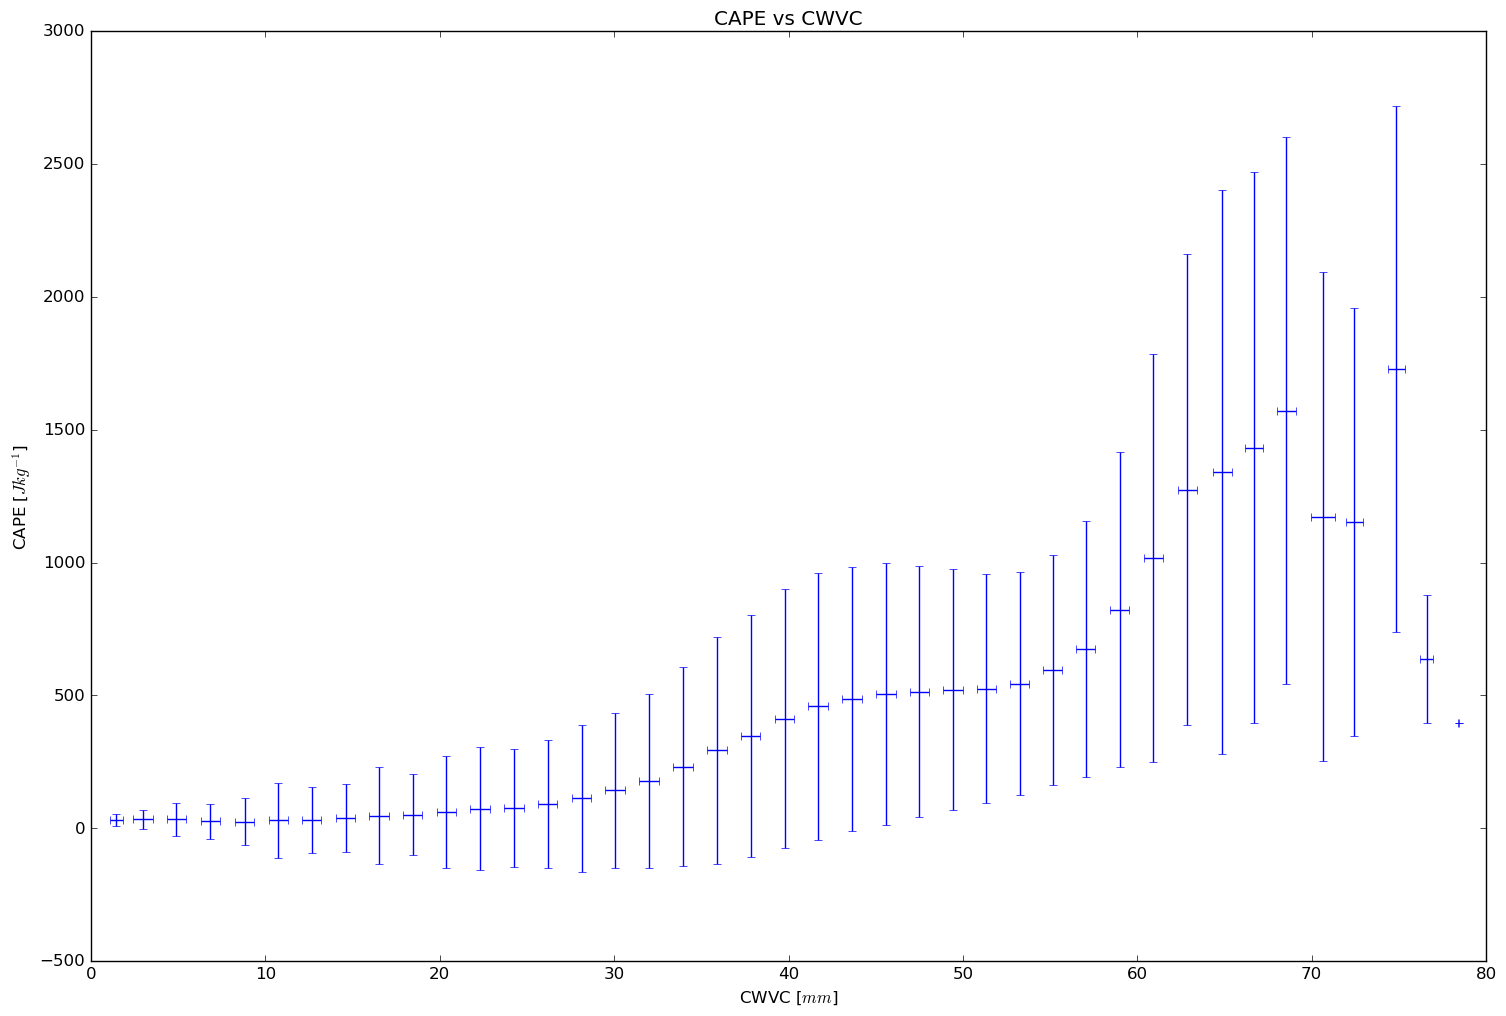

In [16]:
##### Cape vs W cwvc plots

#binning cape values by cwvc
cwvc_bins_2,cape_bins_2,cape_95_bins,cape_99_bins,cwvc_error,cape_error_2,cwvc_max_2,cape_max_2 = bin_stat_function(50,0,95,cwvc,cape,threshold=1) 

#Simple figure created below
fig,ax = plt.subplots(figsize =(18,12))

ax.errorbar(cwvc_bins_2,cape_bins_2,xerr=cwvc_error,yerr=cape_error_2,ls='none')

ax.set(xlabel = "CWVC [$mm$]")

ax.set(ylabel = "CAPE [$J kg^{-1}$]")

ax.set_title("CAPE vs CWVC")

plt.show()

[[ 0.49533326  0.67282702  0.69855318 ...,  0.75555151  0.0380647
   0.88421919]
 [ 0.62424018  0.61638092  0.49467868 ...,  0.78264163  0.09732573
   0.833759  ]
 [ 0.79785789  0.79315036  0.81479507 ...,  0.8931354   0.4686627
   0.87175239]]


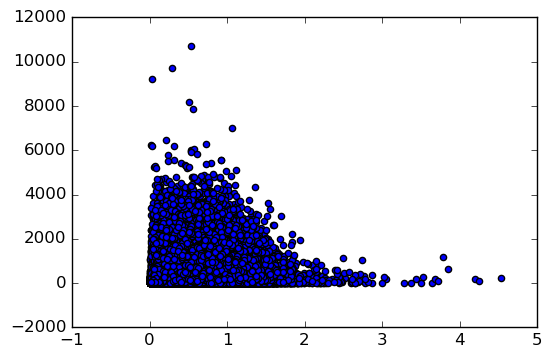

In [17]:
def satVapP_liq(t_in):
    R = 8.314             # J mol-1 K-1
    MWw = 18.015/1000     # kg mol-1
    rhoa = 1.395
    a1 = 54.842763
    a2 = -6763.22
    a3 = -4.21
    a4 = 0.000367
    a5 = 0.0415
    a6 = 218.8
    a7 = 53.878
    a8 = -1331.22
    a9 = -9.44523
    a10 = 0.014025
    factor = a7 + a8/t_in + a9*np.log(t_in) + a10*t_in
    psatL = a1 + a2/t_in + a3*np.log(t_in) + a4*t_in + np.arctan(a5*(t_in - a6))*factor
    psatL = np.exp(psatL)
    return psatL

def find(array,value):
    #simple function to return argument of element closest to desired value
    
    k = np.argmin(abs(array-value))
    
    return k

def find_2(array,value,number):
    #function to find 'number' of initial values in 'array' greater
    #than some 'value'
    
    #indices of values in array greater than the user value
    k = np.where(array>value)
    
    #number of values greater than the value to be chosen
    #i.e. 1 gives the value closest, 2 gives the two closes
    values = (array[k])[:number]
    
    indices = k[0][:number]
    
    return indices,values

def indices_finder(data,values):
    #function using the find_2 function to take the closest element greater than
    # a desired value and returns the indices of desired values
    
    indices = []
    
    for value in values:
    
        indices = np.append(indices, (find_2(data,value,1))[0])
        
    return indices

def avg_function(indices,data,number):
    #function to find values in data corresponding to given indices
    
    #empty array created
    array = [[]]*number
    
    #individual sub arrays are appended to in for loop
    for i in np.arange(number):
    
        array[i] = np.append(array[i],data[:,indices[i]])


    #correct shape zero array to then sum and average manually
    vals = np.zeros(np.shape(array[0]))
    
    #1 less than number of elements desired for average
    for i in np.arange(number-1):

        vals += array[i]
            
    values_avg = vals/(number-1)
    
    return array,values_avg


def rh(qv_value,p_value,t_value):
    #function to calculate relative humidity given water content,pressure and temperature
    
    #return qv_value*(p_value*100 - satVapP_liq(t_value))/((eps*satVapP_liq(t_value)))
    
    #rh_val = qv_value/((eps*satVapP_liq(t_value))/(p_value*100 - satVapP_liq(t_value)))
    
    
    x = eps*satVapP_liq(t_value)/(p_value*100 - satVapP_liq(t_value))
    
    rh_val = qv_value/x
    

    return rh_val

def sd(qv_value,p_value,t_value):
    #function to calculate saturation deficit given water content,pressure and temperature
    
    return (eps*satVapP_liq(t_value))/(p_value*100 - satVapP_liq(t_value)) - qv_value
    

def moisture_function(number,func,qv_value,p_value,t_value):
    #function to output saturdation deficit or relative humidity dependent on input function ( above)
    #up to penultimate values in arrays are used for the functions and then averages calculated
    #at the end
    
    for i in np.arange(number-1):
        
        if i == 0:
            
            #function inputted, sd and rh take same arguments
            array = func(qv_value[i],p_value[i],t_value[i])
            
            
        else:
            
            array = np.vstack((array,func(qv_value[i],p_value[i],t_value[i])))

    
    #empty array initialised
    array_new = np.zeros(np.shape(array[0]))
    
    for i in np.arange(number-1):

        array_new += array[i]
            
    #average calculated
    avg_array = array_new/(number-1)
        
    return avg_array,array  

#opening and compiling temperature,sea surface temp,top temp and water content
temp = nc_open_compile(file_years,"tpre6",compile_type="stack")

sst = nc_open_compile(file_years,"sst")

ttop = nc_open_compile(file_years,"ctt")

qv_2 = nc_open_compile(file_years,"qvpre6",compile_type="stack")


#finding indices of desired pressure values in the pressure data
p_indices = indices_finder(plev,p_vals)


#getting new array with values corresponding to desired pressure levels
#water content and temperature
qv_array,qv_avg = avg_function(p_indices,qv_2,4)

t_array,t_avg = avg_function(p_indices,temp,4)

#relative humidity and saturation deficit values calculated 
rh_avg_arr,rh_arr = moisture_function(4,rh,qv_array,p_vals,t_array)

print((rh_arr))

sd_avg_arr,sd_arr = moisture_function(4,sd,qv_array,p_vals,t_array)


labels_rh = ["Relative Humidity [$-$]",'CAPE [$J kg^{-1}$]',"CAPE vs Relative Humidity"]

labels_sd = ["Saturation Deficit [$-$]",'CAPE [$J kg^{-1}$]',"CAPE vs Saturation Deficit"]

z =rh(qv_2[:,14],plev[14],temp[:,14])

plt.scatter(z,cape)

plt.show()

707968 (3, 707968)


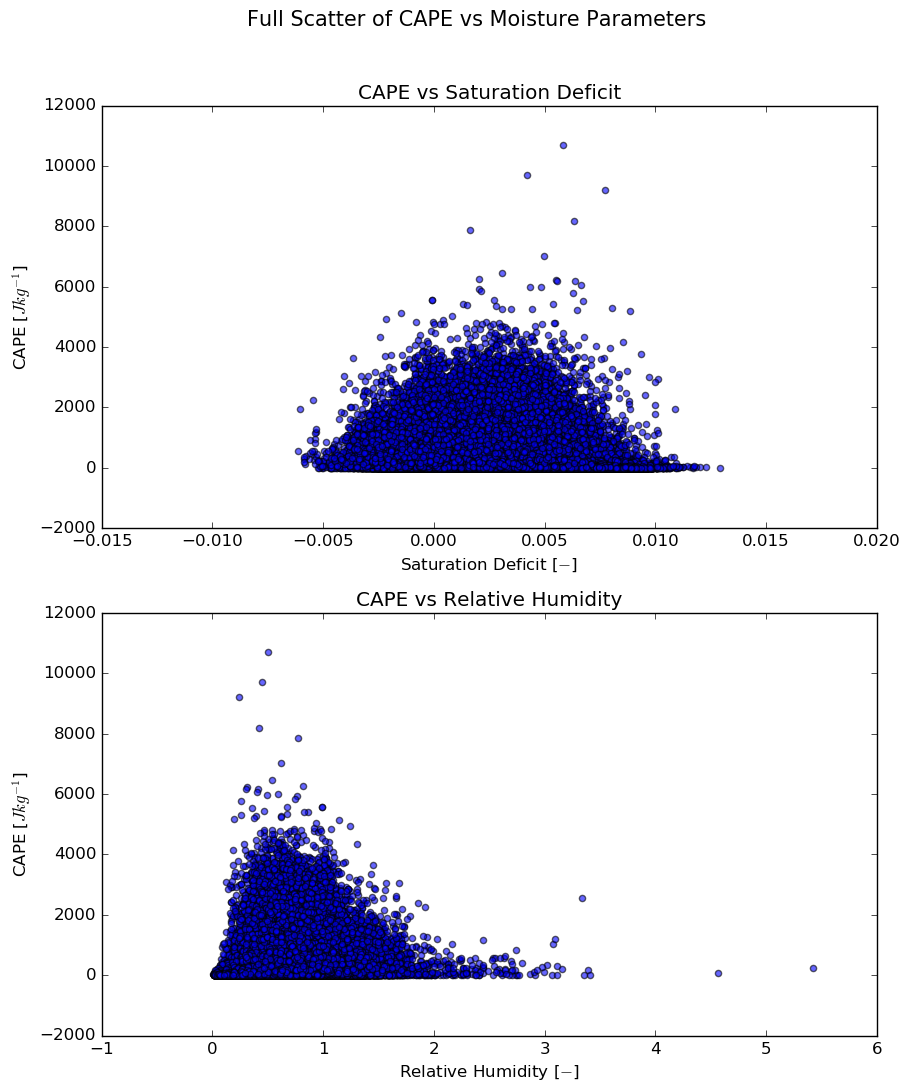

In [24]:
def general_scatter(y_data,x_data,labels,sup_title,a=0.6):
    
    fig,axes = plt.subplots(2,1,figsize=(10,12))
    
    fig.suptitle(sup_title,size=15)
    
    for i,axis in enumerate(axes.flat):
            
        axis.scatter(y_data[i],x_data[i],alpha=a)
                    
        axis.set(xlabel=labels[i][0])
        
        axis.set(ylabel=labels[i][1])
        
        axis.set_title(labels[i][2])
        
    plt.show()
    
    return

print(len(cape),np.shape(rh_arr))
    
general_scatter([sd_avg_arr,rh_avg_arr],[cape,cape],[labels_sd,labels_rh],"Full Scatter of CAPE vs Moisture Parameters")
        

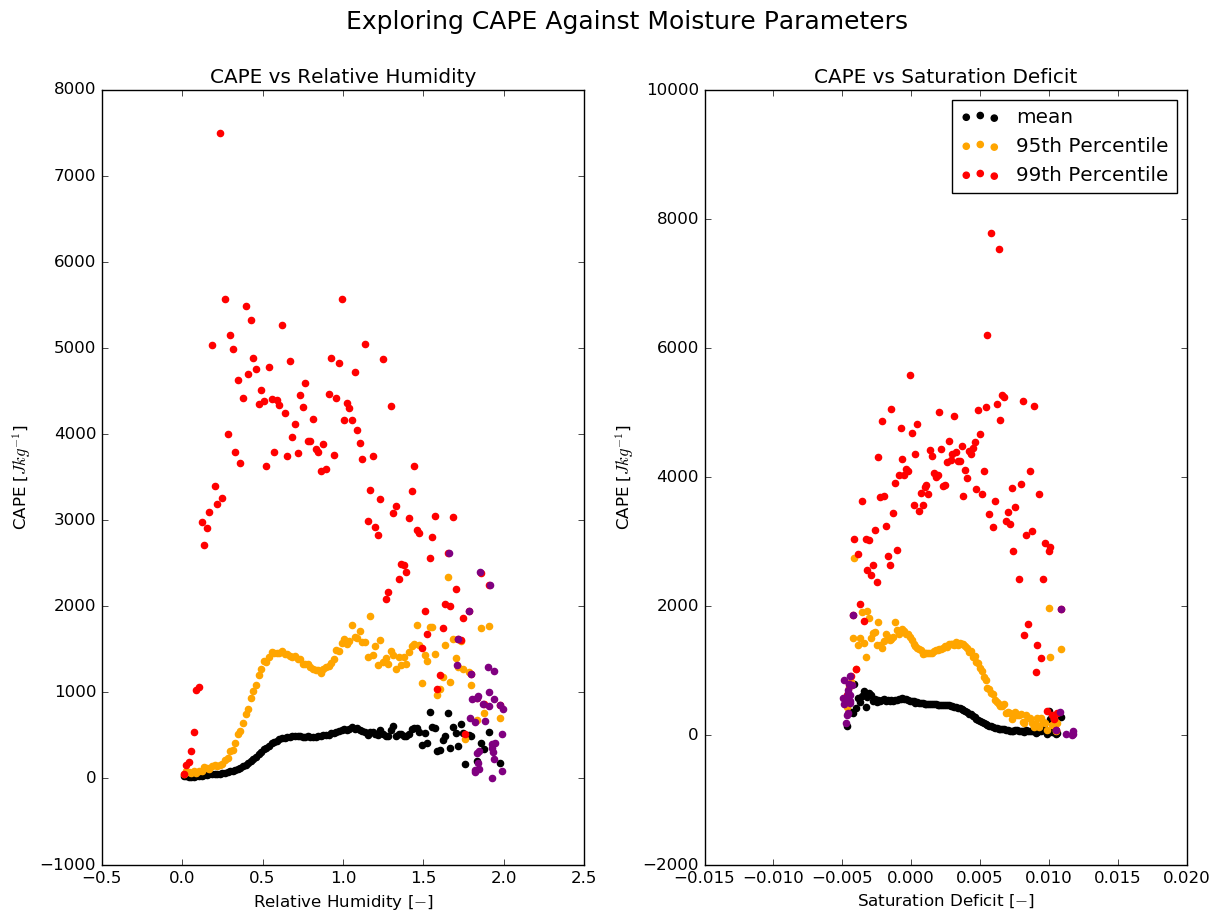

In [37]:
def plot_routine(plot_inputs,labels_inputs,sup_title):
    
    fig,axes = plt.subplots(1,2,figsize = (14,10))
    
    plt.suptitle(sup_title,size=18)
    
    for i,axis in enumerate(axes.flat):
        
        x,y,y_95,y_99,x_err,y_err,x_max,y_max = bin_stat_function(**(plot_inputs[i]))
        
        axis.scatter(x,y,color='black',label='mean')
        
        axis.scatter(x,y_95,color='orange',label='95th Percentile')
        
        axis.scatter(x,y_99,color='red',label='99th Percentile')
        
        axis.scatter(x_max,y_max,color='purple',label='')
        
        axis.set(xlabel=labels_inputs[i][0])
        
        axis.set(ylabel=labels_inputs[i][1])
        
        axis.set_title(labels_inputs[i][2])
    
    
    plt.legend()
    
    #space between plots adjusted
    plt.subplots_adjust(wspace=.25, hspace=0.45)
    
    plt.show()
    
    return


plot_input_rh = {'n_bins':125,'lower':0,'upper':2,'x_variable':rh_avg_arr,'y_variable':cape,'threshold':10,'n_max':5}

labels_rh = ["Relative Humidity [$-$]",'CAPE [$J kg^{-1}$]',"CAPE vs Relative Humidity"]

plot_input_sd = {'n_bins':150,'lower':-0.005,'upper':0.015,'x_variable':sd_avg_arr,'y_variable':cape,'threshold':10,'n_max':5}

labels_sd = ["Saturation Deficit [$-$]",'CAPE [$J kg^{-1}$]',"CAPE vs Saturation Deficit"]

plot_routine([plot_input_rh,plot_input_sd],[labels_rh,labels_sd],'Exploring CAPE Against Moisture Parameters')   


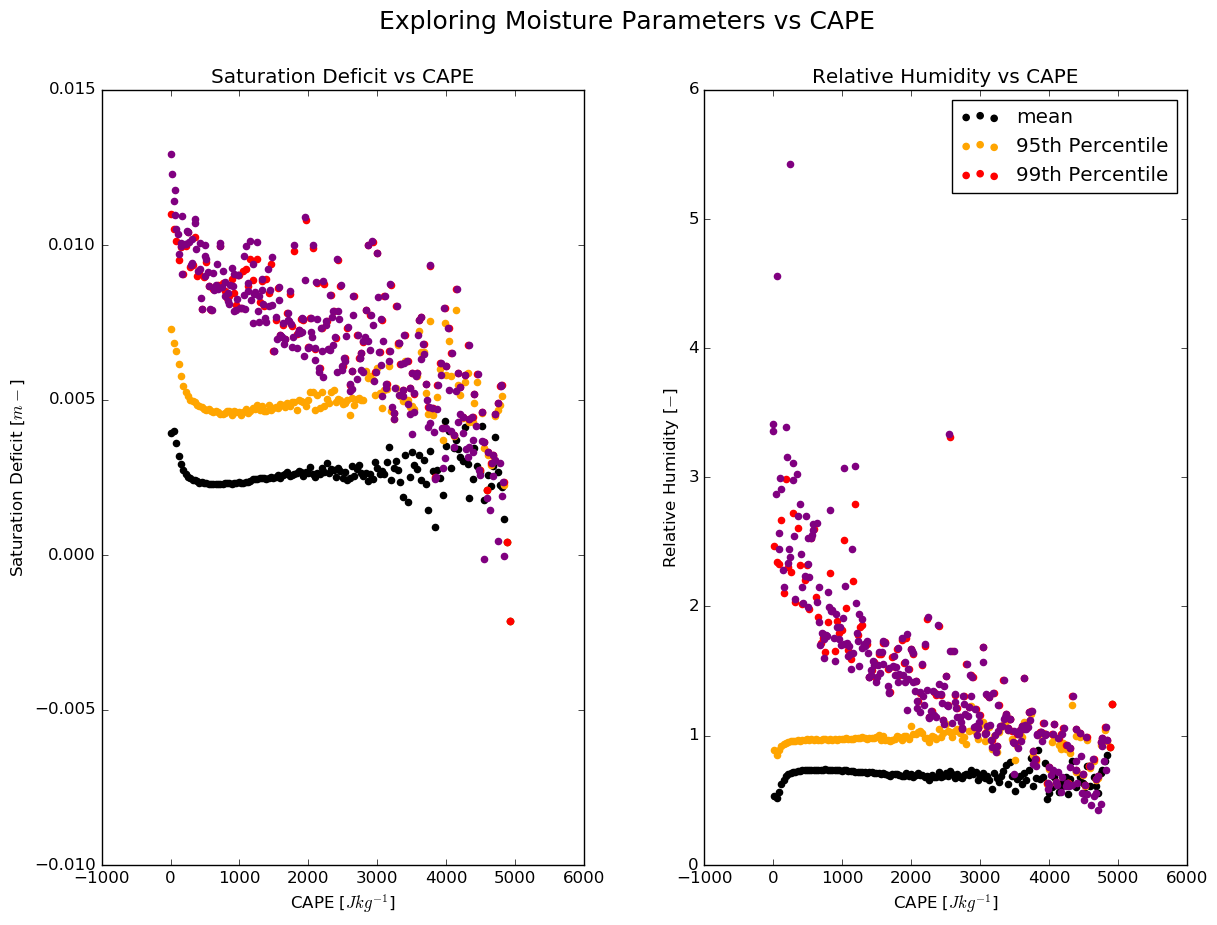

In [43]:
plot_input_s = {'n_bins':150,'lower':0,'upper':5000,'x_variable':cape,'y_variable':sd_avg_arr,'n_max':2}

labels_s = ["CAPE [$J kg^{-1}$]","Saturation Deficit [$m -$]","Saturation Deficit vs CAPE"]

plot_input_r = {'n_bins':150,'lower':0,'upper':5000,'x_variable':cape,'y_variable':rh_avg_arr,'n_max':2}

labels_r = ["CAPE [$J kg^{-1}$]","Relative Humidity [$-$]","Relative Humidity vs CAPE"]

plot_routine([plot_input_s,plot_input_r],[labels_s,labels_r],"Exploring Moisture Parameters vs CAPE")

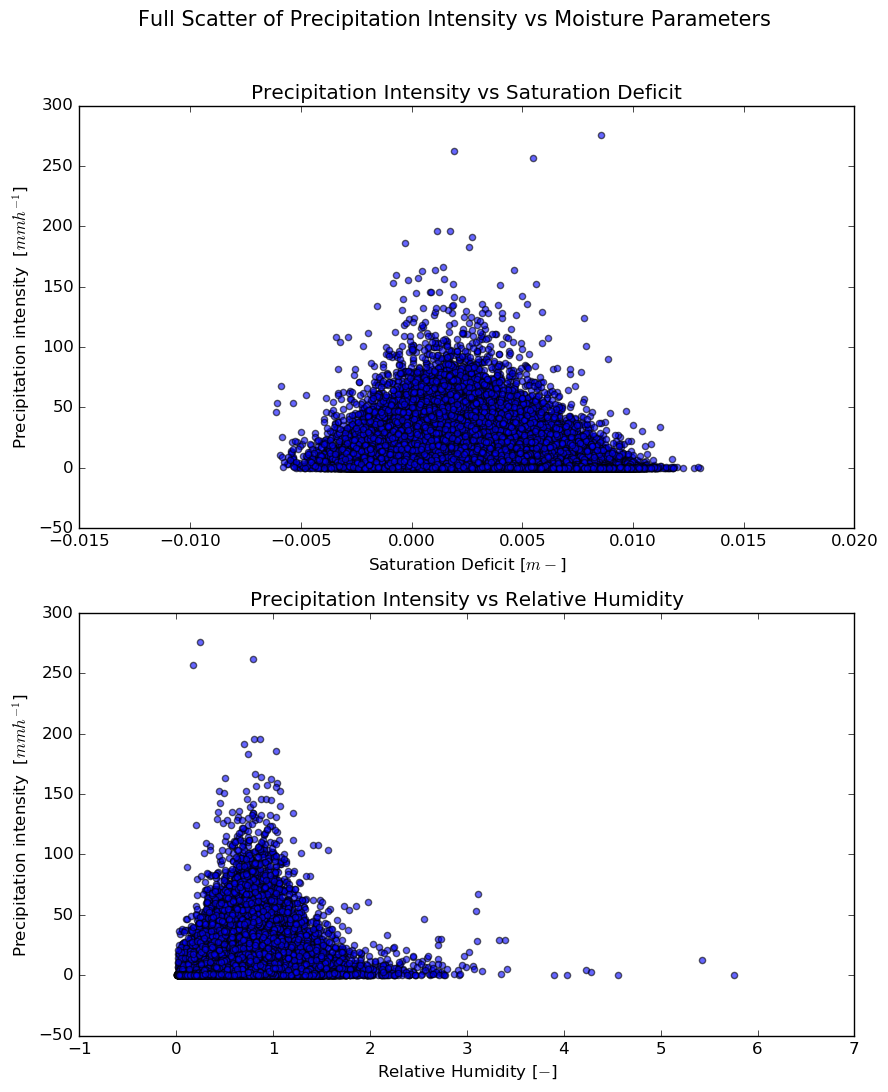

In [35]:
labels_sp = ["Saturation Deficit [$m -$]","Precipitation intensity  [$mm h^{-1}$]","Precipitation Intensity vs Saturation Deficit"]

labels_rp = ["Relative Humidity [$-$]","Precipitation intensity  [$mm h^{-1}$]","Precipitation Intensity vs Relative Humidity"]

general_scatter([sd_avg_arr,rh_avg_arr],[pmax,pmax],[labels_sp,labels_rp],"Full Scatter of Precipitation Intensity vs Moisture Parameters")

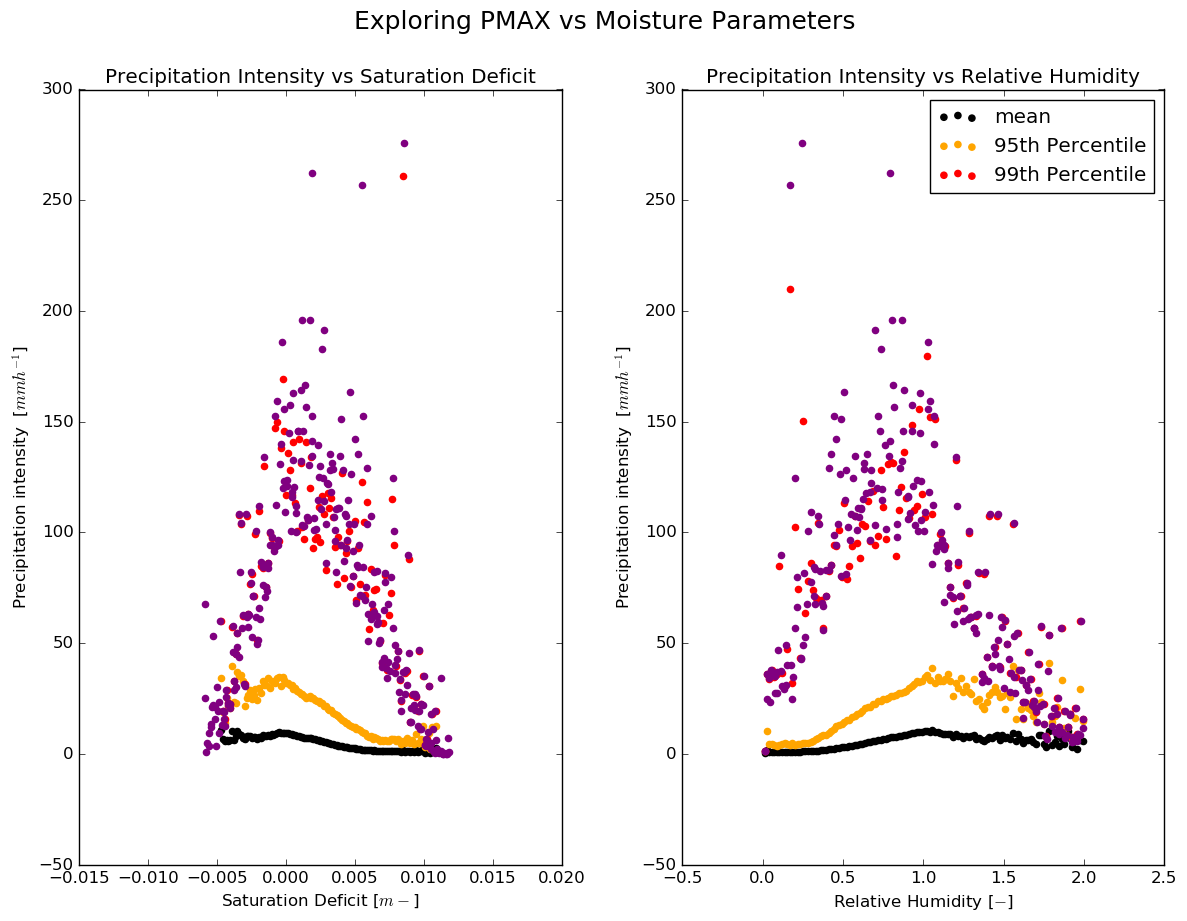

In [40]:
plot_input_sp = {'n_bins':150,'lower':-0.007,'upper':0.0125,'x_variable':sd_avg_arr,'y_variable':pmax,'threshold':10,'n_max':2}

#plot_input_rh = {'n_bins':125,'lower':0,'upper':2,'x_variable':rh_avg_arr,'y_variable':cape,'threshold':10,'n_max':5}

plot_input_rp = {'n_bins':125,'lower':0,'upper':2,'x_variable':rh_avg_arr,'y_variable':pmax,'n_max':2}

plot_routine([plot_input_sp,plot_input_rp],[labels_sp,labels_rp],"Exploring PMAX vs Moisture Parameters")



## Scrap code

In [ ]:
"""
cape = []
pmax = []


#create array of years
years = np.arange(1983,2008)

#create netCDF file name strings and append to empty arrays using xarray
for year in years:
    
    file = 'colloc_' + str(year) + '_NZ.nc'
    
    cape = np.append(cape,(xr.open_dataset(file)).cape.data)
    
    pmax = np.append(pmax,(xr.open_dataset(file)).pmax.data)
    
#replace negative capes and pmaxs with nan    
cape = np.where(cape < 0,np.NaN,cape)
pmax = np.where(pmax < 0,np.NaN,pmax)

#create column vector array
cape = np.reshape(cape,(len(cape),1))
pmax = np.reshape(pmax,(len(pmax),1))
"""

"""
#allocating a number of bins
number_bins = 25

#creating values in a certain range
cc = np.linspace(10,5000,number_bins)

#creating empty arrays in column format
cape_bins = np.zeros((number_bins,1))
pmax_95_bins = np.zeros((number_bins,1))
pmax_99_bins = np.zeros((number_bins,1))
pmax_bins = np.zeros((number_bins,1))

#removing final value for following for loop
cc_new = cc[:-1]

#uses values in cc_new and counters to update empty arrays with percentiles from netcdf files
for i,value in enumerate(cc_new):
    
    jj = np.where(cape >= value and cape < cc[i+1])
    
    #only compute if more than 20 values
    if len(jj) > 20:
        
        #taking means and percentiles of x and y variables in question
        cape_bins[i] = np.mean(cape[jj])
        pmax_bins[i] = np.mean(pmax[jj])
        
        pmax_95_bins[i] = np.percentile(pmax(jj),95)
        pmax_99_bins[i] = np.percentile(pmax(jj),99.99)

"""
"""
#initialising empty arrays
qv = []
pmax_2 = []


#looping over the years again
for year in years:

    #concatenating strings again, could be streamlined as a single function, or create list above
    file = 'colloc_' + str(year) + '_NZ.nc'
    
    #qvpre6 part of netCDF dataset is opened and added to qv 
    qv = np.append(qv,(xr.open_dataset(file)).qvpre6.data)
    
    #repeat again for precipitation
    pmax_2 = np.append(pmax_2,(xr.open_dataset(file)).pmax.data)


qv_array = nc_open_compile(file_years,qv,append)

qv = negative_to_nan(qv_array)



#precipitation treated for negatives and shaped into a column vector    
pmax_2 = np.where(pmax<0,np.nan,pmax_2)

pmax_2 = np.reshape(pmax_2,(len(pmax),1))
"""

"""
#smaller range of values this time
cc = np.linspace(5,65,bb)

#initialising empty arrays as before
cwvc_bins = np.zeros((bb,1))

pmax_95_bins_2 = np.zeros((number_bins,1))

pmax_99_bins_2 = np.zeros((number_bins,1))

pmax_bins_2 = np.zeros((number_bins,1))

#removing final value for following for loop
cc_new = cc[:-1]

#uses values in cc_new and counters to update empty arrays with percentiles from netcdf files
for i,value in enumerate(cc_new):
    
    jj = np.where(cwvc >= value and cwvc < cc[i+1])
    
    #taking means and percentiles of precip and cwvc 
    cwvc_bins[i] = np.mean(cwvc[jj])
    pmax_bins_2[i] = np.mean(pmax[jj])
        
    pmax_95_bins_2[i] = np.percentile(pmax(jj),95)
    pmax_99_bins_2[i] = np.percentile(pmax(jj),99.99)

#(no requirement for 20 place values this time?)
"""


"""
fig,(ax1,ax2) = plt.subplots(2,1,figsize =(13,12))

#Superior title created to contain damping information
fig.suptitle("Exploring precipitation variation")

#Precipitation as function of CAPE
ax1.scatter(cape_bins.flatten(), pmax_bins.flatten(),color = 'blue')

ax1.set(xlabel = "CAPE (pre6) [$J kg^{-1}$]")
ax1.set(ylabel = "$P_{max}$  [$mm h^{-1}$]")

ax1.set_title("Precipitation vs CAPE")

#Precipitation as a function of cwvc
ax2.scatter(cwvc_bins.flatten(),pmax_bins_2.flatten(),color = 'blue')

ax2.set(xlabel = "CWVC (pre6) [$mm$]")
ax2.set(ylabel = "$P_{max}$  [$mm h^{-1}$]")

ax2.set_title("Precipitation against CWVC")

plt.show()
"""
"""
fig, ax = plt.subplots(3,1, figsize =(18,12))
    
fig.suptitle('Exploring precipitation intensity vs CAPE',fontsize =20)
    
legend_labels = ('Pmax Mean','Pmax 95th %','Pmax 99th %')
    
precip_arrays = [pmax_bins,pmax_95_bins,pmax_99_bins]
                         
#ax.flat allows iteration through the subplots
for i, axis in enumerate(ax.flat):
        
    axis.scatter(cape_bins.flatten(), (precip_arrays[i]).flatten(), label = legend_labels[i],color = 'blue')
    axis.set(xlabel = "CAPE (pre6) [$J kg^{-1}$]")
    axis.set(ylabel = "Precipitation intensity  [$mm h^{-1}$]")
    axis.set_title("{} ".format(legend_labels[i]))
    axis.legend()
  
plt.show()



fig, ax = plt.subplots(3,1, figsize =(18,12))
    
fig.suptitle('Exploring precipitation intensity vs CWVC',fontsize =20)
    
legend_labels = ('Pmax Mean','Pmax 95th %','Pmax 99th %')
    
precip_arrays = [pmax_bins_2,pmax_95_bins_2,pmax_99_bins_2]
                         
#ax.flat allows iteration through the subplots
for i, axis in enumerate(ax.flat):
        
    axis.scatter(cwvc_bins.flatten(), (precip_arrays[i]).flatten(), label = legend_labels[i],color = 'blue')
    axis.set(xlabel = "CWVC (pre6) []")
    axis.set(ylabel = "Precipitation intensity  [$mm h^{-1}$]")
    axis.set_title("{} ".format(legend_labels[i]))
    axis.legend()
    
    plt.subplots_adjust( wspace=.35, hspace=0.45)
        
plt.show()
"""
#cape[~np.isnan(cape)]



#def rh_function(qv_arr,p_vals,t_arr):
    
 #   return (qv_arr[3]*(p_vals[2]*100 - SATVPLIQUID(t_arr[3])))/(eps*SATVPLIQUID(t_arr[3]))


"""
def rh_avg_function(qv_arr,p_vals,t_arr,number):
    
    
    for i in np.arange(number-1):
        
        if i == 0:
            
            rhs = qv_arr[i]*(p_vals[i]*100 - satVapP_liq(t_arr[i]))/((eps*satVapP_liq(t_arr[i])))
            
        else:
            
            rhs = np.vstack((rhs,qv_arr[i]*(p_vals[i]*100 - satVapP_liq(t_arr[i]))/((eps*satVapP_liq(t_arr[i])))))

    rh = np.zeros(np.shape(rhs[0]))
    
    for i in np.arange(number-1):
        
        rh += rhs[i]
        
    rh_avg = rh/(number-1)
        
    return rh_avg
"""


"""
def avg_function(indices,data,number):
    
    array = [[]]*number
    
    for k,year in enumerate(years):
    
        for i in np.arange(number):
    
            array[i] = np.append(array[i],data[k,indices[i]])
        
    print(array)
    
    vals = np.zeros(np.shape(array[0]))
        
    for i in np.arange(number-1):
            
        vals += array[i]
            
    vals_avg = vals/(number-1)
    
    return array,vals_avg

#### read here for direct matlab 

indices = []

for p in p_vals:
    
    indices = np.append(indices, (find_2(plev,p,1))[0])

qvs = [[],[],[],[]]

ts = [[],[],[],[]]

rhs = [[],[],[]]

pr,epac,tss,pott=[],[],[],[]

#qv_2 = nc_open_compile(file_years,"qvpre6",compile_type="stack")
#not sure I need the qvpre6 or if i can just use qv

for year in years:
    
    for i in np.arange(4):
    
        qvs[i] = np.append(qvs[i],qv[:,indices[i]])
    
        ts[i] = np.append(ts[i],temp[:,indices[i]])

avg = 1

if avg == 1:
    
    qv_avg = (qvs[0]+qvs[1]+qvs[2])/3
    
    t_avg = (ts[0] + ts[1] + ts[2])/3
    
    for i in np.arange(3):
        
        if i == 0:
            
            rhs = qvs[i]*(p_vals[i]*100 - satVapP_liq(ts[i]))/((eps*satVapP_liq(ts[i])))
            
            sds = (eps*satVapP_liq(ts[i])/(p_vals[i]*100 - satVapP_liq(ts[i]))) - qvs[i]
            
        else:
            
            rhs = np.vstack((rhs,qvs[i]*(p_vals[i]*100 - satVapP_liq(ts[i]))/((eps*satVapP_liq(ts[i])))))

            sds = np.vstack((sds,(eps*satVapP_liq(ts[i])/(p_vals[i]*100 - satVapP_liq(ts[i]))) - qvs[i]))
    
    rh = (rhs[0]+rhs[1]+rhs[2])/3
    
    sd = (sds[0]+sds[1]+sds[2])/3

cape_bins_s,sd_bins,sd_95_bins,sd_99_bins,cape_error_s,sd_error = bin_stat_function(150,0,5000,cape,sd_arr,threshold=20)

cape_bins_r,rh_bins,rh_95_bins,rh_99_bins,cape_error_r,rh_error = bin_stat_function(150,0,5000,cape,rh_arr,threshold=20)


#sd_x,cape_ys,cape_95_ys,cape_99_ys,sd_x_error,cape_ys_error = bin_stat_function(50,-0.1,0.1,sd_arr,cape,threshold=20)




#print(np.nanmax(cape_ys))

#plt.scatter(cape_bins_s,sd_bins*1000)
#plt.show()


fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,13))


ax1.scatter(cape_bins_s,sd_bins*1000,color='black',s=30)

ax1.scatter(cape_bins_s,sd_95_bins*1000,color='orange',s=15)

ax1.scatter(cape_bins_s,sd_99_bins*1000,color='red',s=15)



ax1.set(xlabel = "CAPE [$J kg^{-1}$]")

ax1.set(ylabel = "Saturation Deficit [$m -$]")

ax1.set_title("Saturation Deficit vs CAPE")



ax2.scatter(cape_bins_r,rh_bins,color='black',s=30)

ax2.scatter(cape_bins_r,rh_95_bins,color='orange',s=15)

ax2.scatter(cape_bins_r,rh_99_bins,color='red',s=15)



ax2.set(xlabel = "CAPE [$J kg^{-1}$]")

ax2.set(ylabel = "Relative Humidity [$-$]")

ax2.set_title("Relative Humidity vs CAPE")

plt.show()


"""

"""
sd_x,cape_y,cape_95_y,cape_99_y,sd_error_x,cape_error = bin_stat_function(150,-0.007,0.0125,sd_arr,cape,threshold=10)

plt.scatter(sd_x,cape_y)

plt.show()

plt.scatter(sd_x,cape_95_y)

plt.show()

plt.scatter(sd_x,cape_99_y)

plt.show()

plt.scatter(sd_arr,cape,alpha=0.35)

plt.show()

fig,ax1




rh_x,cape_y,cape_95_y,cape_99_y,rh_error_x,cape_error = bin_stat_function(125,0,2,rh_arr,cape,threshold=10)

plt.scatter(rh_x,cape_y)

plt.show()

plt.scatter(rh_x,cape_95_y)

plt.show()

plt.scatter(rh_x,cape_99_y)

plt.show()

plt.scatter(rh_arr,cape,alpha=0.35)

plt.show()



fig,(ax1,ax2) = plt.subplots(2,1,figsize=(10,12))

ax1.scatter(sd_arr,cape)

ax2.scatter(rh_arr,cape)

plt.show()

y_data = [sd_arr,rh_arr]


def precip_plot(x_bins,x_name_unit,precip_arrays,x_mean_error,precip_mean_error):
    #plots x bin values against precip bin values
    
    #x_bins is simple array of bin values, x_name_unit is an array with the variable name and units 
    #in string type, precip_arrays is an array containing the 3 types of precip data

    fig, ax = plt.subplots(2,2, figsize =(18,14))
    
    fig.suptitle('Exploring precipitation intensity vs '+x_name_unit[0],fontsize =20)
    
    #list of labels to be iterated through
    legend_labels = ('Precipitation Mean','Precipitation 95th %',
                     'Precipitation 99th %','Precipitation Max')
                         
    #ax.flat allows iteration through the subplots
    for i, axis in enumerate(ax.flat):
        
       
        if i == 0:
            
            axis.errorbar(x_bins[0].flatten(), (precip_arrays[i]).flatten(),xerr=x_mean_error.flatten(),
                          yerr=precip_mean_error.flatten(), label=legend_labels[i],color = 'blue',ls='none')
            
            axis.legend(loc='upper left')
                          
        
        elif i == 3:
            
            axis.scatter(x_bins[1].flatten(), (precip_arrays[i]).flatten(), label = legend_labels[i],color = 'blue')
            
        else:
            
            #arrays flattened, precip arrays iterated through
            axis.scatter(x_bins[0].flatten(), (precip_arrays[i]).flatten(), label = legend_labels[i],color = 'blue')
        
        
        
        #x variable unit and name formatted in
        axis.set(xlabel = x_name_unit[0] + " [${}$]".format(x_name_unit[1]))
        axis.set(ylabel = "Precipitation intensity  [$mm h^{-1}$]")
        axis.set_title("{} ".format(legend_labels[i]))
    
    #space between plots adjusted
    plt.subplots_adjust(wspace=.15, hspace=0.25)
        
    plt.show()

#plots called for cape and cwvc
#precip_plot([cape_bins,cape_max],['CAPE','J kg^{-1}'],precip_bin_arrays,cape_error,pmax_error)

#all_labels = [suptitle,[x_name,x_unit],[y_name,y_unit]]
"""

In [ ]:
print(np.arange(3))

In [ ]:
x = np.array([1,2,3,4])

y = np.array([5,2,5,3])

z = (x+y)/2

print(z)

In [ ]:
x = np.empty([4,1,1]).flatten()
print(x)

number = 5

y = [[]]

z = y*number

print(z)

In [ ]:
len(years)

In [ ]:
val = 5

val += 10

In [ ]:
print(val)

In [ ]:
print(np.arange(4))

i = 0

x = np.array([1,2,3])

y = np.array([3,4,5])

d = [x,y]

z = np.zeros([np.shape(x)])

for i in range(2):
    
    z += d[i]
    
print(z)
    
print(x + y) 

In [ ]:
print(range(3))

In [ ]:
x_vals = np.arange(10)

def cube_func(x):
    
    return x_arr**3

def ten_func(x):
    
    return x_arr + 10


In [ ]:
def master_func(func,x_arr):
    
    y = func(x_arr)
    
    return y 

master_func(ten_func,x_vals)

In [ ]:
x = [1,2,3]
y = np.array([7,8,9])

z = x*3

print(z)

In [ ]:
b = rh(qv_array[0],p_vals[0],t_array[0])

In [ ]:
np.empty(3,5)

In [ ]:
x = ['hey',' paul']

print(x[0]+x[1])

In [ ]:
x = np.array([1,3,5])
y = np.array([2,5,6])
z = np.array([3,8,11])

def func_test(value):
    
    return value**2 + 5

func_test(x)

(x+y+z)/3

In [ ]:
number = 4


z = np.empty((1,2*number + 1))

print(z)

z[0][number] = 5

print(z)

In [ ]:
indicess = np.arange(0,25)

print(indicess)

l = 6

number = 3

interest = indicess[l-(number+1):l+number]

print(interest)

print(len(interest))

In [ ]:
b = [1:5]